# Time Series Analysis

## First Part - Necessary Code

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import datetime


import statsmodels.api as sm
import statsmodels as sms
from statsmodels.tsa.seasonal import seasonal_decompose

from IPython.display import Video

In [2]:
# Colors
green = "#03AC13"

# Import company colors
with open('plot_colors.json', 'r') as pc:
    color_dict = json.load(pc)

c_light, c_dark, c_blue = color_dict['color_light'], color_dict['color_dark'], color_dict['color_blue']

# Define color map for plotting
color_map = ListedColormap([c_blue, c_light, c_dark])

cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

### EDA - Hands On

In [3]:
def plot_ts(ts = None, ts_add = None, title ='Time Series', legend=['1'], figsize=(10, 4), fill_bw=False, n_fill_bw=None, fill_bw_range=None, fill_bw_range_y=None):
    """
    Plots one or two time series in a single plot
    
        Args:
        ts: 1d- or 2d-array of time series. Dimension
            must be (n,) or (n,2)
        title: Title for the time plot.
        legend: list of legend names. If empty no legend.
        
        Returns:
        matplotlib plot object
    """
    plt.figure(figsize=figsize)
    plt.plot(ts[:,], color=c_light)
    plt.grid(True,axis='y')
    plt.title(title)
    if ts_add is not None:
        plt.plot(ts_add, color=c_dark)
    if len(legend) > 0:
        plt.legend(legend)       
    if fill_bw == True: 
        color_list=[c_light,c_dark,c_blue,green]
        t = np.arange(0,len(ts)+1,1)
        for i in range(0,n_fill_bw):
            plt.fill_between(x= t, y1=fill_bw_range_y[1], y2=fill_bw_range_y[0], where= (fill_bw_range[i][0] <= t)&(t <= fill_bw_range[i][1]), color= color_list[i], alpha= 0.2)
            plt.fill_between(x= t, y1=fill_bw_range_y[1], y2=fill_bw_range_y[0], where= (fill_bw_range[i][0] <= t)&(t <= fill_bw_range[i][1]), color= color_list[i], alpha= 0.2)

    plt.show()

In [4]:
def dpg_trend(fill=False, n_fill=None, fill_range=None, fill_range_y=None):
    # Define a DGP with a linear and quadratic trend
    np.random.seed(42)

    # Sample a normal white noise 
    y = np.random.normal(0.0, 0.4, 100)

    # Construct the time series with linear and quadratic trend
    trend = 0.1 + 0.07 * np.arange(0,100)
    y_ln = trend + y
    y_qd = y_ln + 0.001 * np.arange(0,100)**2

    # Plot the series
    plot_ts(y_ln, y_qd, title = 'Linear and Quadratic Trend', legend=['Linear', 'Qaudratic'], fill_bw=fill, n_fill_bw=n_fill, fill_bw_range=fill_range, fill_bw_range_y=fill_range_y)
   

def dpg_seasonality(fill=False, n_fill=None, fill_range=None, fill_range_y=None):
    # Define the DGP
    np.random.seed(42)

    # Define the white noise process
    error = np.random.normal(0.0, 1.1, 300)

    # Define the seasonal pattern
    # Use Fourier Series with a single sinus pattern
    # with period 60.
    seasonal = np.sin((2*np.pi/60)*np.arange(1,301))

    # Combine the two terms and plot the series
    y = seasonal + error
    plot_ts(y, title = 'Seasonality',legend=['Cycle d=60'], fill_bw=fill, n_fill_bw=n_fill, fill_bw_range=fill_range, fill_bw_range_y=fill_range_y)
    

def ar_1():
    # Sample a simple AR(1) process.
    np.random.seed(42)
    y = sm.tsa.ArmaProcess(ar=[1,-0.7]).generate_sample(nsample=500)
    plot_ts(y, title='', legend=['AR(1)'])   

### Components of TS

In [5]:
data_df_weather = pd.read_csv('../data/basel_weather.csv')

# Rename columns in a more pythonic way
data_df_weather = data_df_weather.rename(columns={
    'Basel Temperature [2 m elevation corrected]': 'temperature', 
    'Basel Precipitation Total': 'precipitation', 
    'Basel Wind Speed [10 m]': 'wind_speed', 
    'Basel Wind Direction [10 m]': 'wind_direction'
    }
)

# Convert timestamp to datetime object
# Extract additional features from timestamp column
data_df_weather = data_df_weather.assign(
    timestamp = lambda x: pd.to_datetime(x['timestamp']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear,
    hour = lambda x: x['timestamp'].dt.hour,
)

# Aggregate temperature by day
daily_data_df = data_df_weather \
    .groupby(['date', 'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'temperature': np.mean}) \
    .set_index('date')

# We use the parameter `period` = 365 to extract the yearly seasonality. 
seas_decomp_yearly = seasonal_decompose(
    x=daily_data_df['temperature'], 
    model='additive', 
    period=365
)

/var/folders/5y/2lyn0j_n5d5_28ws_q262c1c0000gn/T/ipykernel_16956/964007368.py:27: FutureWarning: The provided callable <function mean at 0x10a142200> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg({'temperature': np.mean}) \


### Imputation and Train - Test - Split

In [6]:
def plot_ts_nan(ts = None, ts_add = None, title ='Time Series', legend=['1']):

    t = [t_i for t_i in range(0,len(y_acf_pacf))]

    plt.figure(figsize=(16, 6))
    plt.plot(ts[:17,], color=c_light)
    plt.plot(t[20:54],ts[20:54,], color=c_light)
    plt.plot(t[56:68],ts[56:68,], color=c_light)
    plt.plot(t[71:],ts[71:,], color=c_light)
    plt.grid(True,axis='y')
    plt.title(title)
    if ts_add is not None:
        plt.plot(ts_add, color=c_dark)
    if len(legend) > 0:
        plt.legend(legend)

    plt.show()

In [7]:
# Sample an AR(3) process and plot the ACF and PACF
np.random.seed(42)
process=sm.tsa.ArmaProcess(ar=[1, -0.4, 0.7, -0.1])
y_acf_pacf = process.generate_sample(nsample=100)

In [8]:
def plot_ts_split(ts = None, ts_add = None, title ='Time Series', legend=['1']):

    t = [t_i for t_i in range(0,len(y_acf_pacf))]

    plt.figure(figsize=(16, 6))
    plt.plot(ts[:91,], color=c_light)
    plt.plot(t[90:],ts[90:,], color=c_blue)
    plt.grid(True,axis='y')
    plt.title(title)

    plt.axvline(x=90, color=c_dark, ls="--")

    if ts_add is not None:
        plt.plot(ts_add, color=c_dark)
    if len(legend) > 0:
        plt.legend(legend)

    plt.show()

### ARMA cake example

In [9]:
# Start by Gernerating the random series; Normaly distributed with mu=100 and sig=10
np.random.seed(42)
data_cake = np.random.normal(100, 10, 1420)

#We start with some inital values to avoid NANs generated by the shift
stock_today=[250,250] 
stock_today=[0,0] 
prod_YesterOneday=[0,0]
prod_YesterTwoDay=[0,0]
picked_yesterOnedaysProd=[0,0]
picked_yesterTwodaysProd=[0,0] 
eaten=[0,0]
prod_Today=[0,100]

for dat in data_cake:
    prod_YesterOneday.append(prod_Today[-1])
    prod_YesterTwoDay.append(prod_Today[-2])
    prod_Today.append(dat)
    picked_yesterOnedaysProd.append(prod_YesterOneday[-1]*0.4)
    picked_yesterTwodaysProd.append(prod_YesterTwoDay[-1]*0.2)
    eaten.append(stock_today[-1]*0.15)
    stock_today.append(stock_today[-1]
                       -eaten[-1]
                       +prod_Today[-1]
                       -picked_yesterOnedaysProd[-1]
                       -picked_yesterTwodaysProd[-1])
    
df_cake=pd.DataFrame(data={'prod_Today':prod_Today,
                      'prod_YesterOneday':prod_YesterOneday,
                      'prod_YesterTwoDay':prod_YesterTwoDay,
                      'picked_yesterOnedaysProd':picked_yesterOnedaysProd,
                      'picked_yesterTwodaysProd':picked_yesterTwodaysProd,
                      'eaten':eaten,
                      'stock_today':stock_today})
df_cake=df_cake.iloc[2:].reset_index(drop=True)
df_cake=df_cake.iloc[20:].reset_index(drop=True)

#Use the 10 most recent values for testing
train_cake,test_cake = df_cake.stock_today[:-15],df_cake.stock_today[-15:]

#Train the model
mod = sms.tsa.arima.model.ARIMA(train_cake, order=(1, 0, 2),)
res = mod.fit()

In [10]:
# Plot the predicted stock price and original price

def cakestore_modelperformance_signal():
    fig,ax = plt.subplots(1,1,figsize=(12,5), dpi=200)
    plt.plot(df_cake.stock_today, label='Signal',color=c_dark)


    plt.title('Cakestore modelperformance')
    plt.xlabel('Day')
    plt.ylabel('Cakes in store')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlim(1250,1400)
    plt.ylim(230,300)
    ax.grid()
    plt.show()

In [11]:
# Forecasting values

def cakestore_modelperformance():
    in_series_prediction= res.predict() 
    forecast_values =res.forecast(15)

    pv_series = pd.Series(in_series_prediction, index=train_cake.index)
    fcv_series = pd.Series(forecast_values, index=test_cake.index)

    # Plot the predicted stock price and original price
    fig,ax = plt.subplots(1,1,figsize=(12,5), dpi=200)
    plt.plot(train_cake, label='Training',color=c_dark)
    plt.plot(test_cake, '--',label='Testdata',color=c_dark)
    plt.plot(mean_pred:=[train_cake.mean()]*(len(train_cake)+len(test_cake)), label='mean(train)',color="green")
    plt.plot(pv_series,label='Prediction ARMA',color=c_light)
    plt.plot(fcv_series,'--',label='Forecast ARMA',color=c_light)

    plt.title('Cakestore modelperformance')
    plt.xlabel('Day')
    plt.ylabel('Cakes in store')
    #plt.xticks([])
    plt.legend(loc='upper left', fontsize=8)
    plt.xlim(1250,1400)
    plt.ylim(230,300)
    ax.grid()
    plt.show()

In [12]:
def print_rmse():
    mean_pred=[train_cake.mean()]*(len(train_cake)+len(test_cake))

    in_series_prediction= res.predict()
    forecast_values =res.forecast(15)

    pv_series = pd.Series(in_series_prediction, index=train_cake.index)

    RMSE_mean_train=np.sqrt(np.mean((mean_pred[:-15]-train_cake)**2))
    RMSE_ARMA_train=np.sqrt(np.mean((pv_series-train_cake)**2))
    print(f"Train RMSE of predict_mean: {round(RMSE_mean_train,2)}")
    print(f"Train RMSE of predict_ARMA: {round(RMSE_ARMA_train,2)}")

    RMSE_mean_test=np.sqrt(np.mean(([train_cake.mean()]*15-test_cake)**2))
    RMSE_ARMA_test=np.sqrt(np.mean((forecast_values-test_cake)**2))
    print(f"Test RMSE of predict_mean: {round(RMSE_mean_test,2)}")
    print(f"Test RMSE of predict_ARMA: {round(RMSE_ARMA_test,2)}")

### Forecasting with ARMA

In [13]:
 def plot_arma():
        
    # Generate an AR(2) process
    np.random.seed(42)
    ar_proc = sm.tsa.ArmaProcess(ar = [1, -.7, -.2]).generate_sample(nsample=1000)

    # Define trend and seasonal component
    seasonal = 1.3 * np.sin(2*np.pi/4*np.arange(1,1001))
    trend = 0.01 + 0.02 * np.arange(1, 1001) 
    y = trend + ar_proc + seasonal

    # The grid search suggests a SARIMA model with 2 AR lag and 2 MA lags
    # for both the main component and the seasonal component.
    np.random.seed(42)
    sarima_model = sm.tsa.SARIMAX(y, order = (2, 1, 2), seasonal_order=(2, 1, 2, 4), enforce_invertibility=False, enforce_stationarity=False)
    res = sarima_model.fit(disp=0)

    # Let us make some predictions for the last indices 
    # in the time series
    pred = res.predict(980, 999)
    y_pred = np.ndarray((100,))

    # Set the points not forecasted to NaN 
    # (this does not plot them)
    y_pred[:80] = np.NaN 
    y_pred[80:] = pred

    # Print the forecast RMSE.
    plot_ts(y[900:], y_pred, title = '20-step ahead forecast', legend=['Orig.', 'Est.'])

### ACF / PACF

In [14]:
df_acf_pacf=pd.DataFrame()
df_acf_pacf=df_acf_pacf.assign(y=y_acf_pacf)
df_acf_pacf=df_acf_pacf.assign(y=y_acf_pacf,
          yL1=df_acf_pacf.y.shift(1),
          yL2=df_acf_pacf.y.shift(2),
          yL3=df_acf_pacf.y.shift(3))

In [15]:
df_acf_pacf=df_acf_pacf.dropna()

In [16]:
def acf_pacf(df):
    fig, ax = plt.subplots(1, 2, figsize = (12,4))

    sm.tsa.graphics.plot_acf(df.y,color = c_light,lags=10, ax = ax[0],alpha=0.05)
    sm.tsa.graphics.plot_pacf(df.y,color = c_light, lags = 10, ax = ax[1],alpha=0.05)
    plt.setp(ax, ylim=(-0.825,1.125))
    

In [17]:
def acf_pacf_steps(df):
    
    y_temp=df.y
    #X= sm.add_constant(df.yL1) #if you want you can try out whether including the intercept makes sense, however in our synthetic example it is irrelevant.
    X_temp=df.yL1
    PACF_OLS_1=sm.OLS(y_temp,X_temp) #Predict the signal from 1. lagged value

    RES_PACF_OLS_1=PACF_OLS_1.fit()
    RESID_PACF_OLS_1=RES_PACF_OLS_1.resid #Here it gets interesing (see below())

    df=df.assign(yL1_decorr=RES_PACF_OLS_1.resid)

    y_temp=df.yL1_decorr
    X_temp= sm.add_constant(df.yL2)
    X_temp= df.yL2
    PACF_OLS_2=sm.OLS(y_temp,X_temp)

    RES_PACF_OLS_2=PACF_OLS_2.fit() #Predict the first residuals from 2. lagged value
    RESID_PACF_OLS_2=RES_PACF_OLS_2.resid

    df=df.assign(yL2_decorr=RES_PACF_OLS_2.resid)

    y_temp=df.yL2_decorr
    X_temp= sm.add_constant(df.yL3)
    X_temp= df.yL3
    PACF_OLS_3=sm.OLS(y_temp,X_temp)

    RES_PACF_OLS_3=PACF_OLS_3.fit()#Predict the second residuals from 3. lagged value
    RESID_PACF_OLS_3=RES_PACF_OLS_3.resid

    df=df.assign(yL3_decorr=RES_PACF_OLS_3.resid)
    
    fig, ax = plt.subplots(2,3,figsize = (24,12))

    sns.regplot(x=df.yL1,y=df.y,ax=ax[0,0],line_kws={"color": c_light})
    sns.regplot(x=df.yL2,y=df.yL1_decorr,ax=ax[0,1],line_kws={"color": c_light})
    sns.regplot(x=df.yL3,y=df.yL2_decorr,ax=ax[0,2],line_kws={"color": c_light})

    sns.regplot(x=df.yL1,y=df.yL1_decorr,ax=ax[1,0],line_kws={"color": c_light})
    sns.regplot(x=df.yL2,y=df.yL2_decorr,ax=ax[1,1],line_kws={"color": c_light})
    sns.regplot(x=df.yL3,y=df.yL3_decorr,ax=ax[1,2],line_kws={"color": c_light})


    for i in range(2):
        for j in range(3):
            ax[i,j].grid()
    fig.suptitle('Steps for creating the PACF', fontsize=24,weight="bold")

    ax[0,0].set_title("First step: fitting the signal to first lagged signal")
    ax[1,0].set_title("Second step: taking the residuals from first step")
    ax[0,1].set_title("Third step: fitting the first residuals to the second lagged signal")
    ax[1,1].set_title("Fourth step: taking the residuals from third step")
    ax[0,2].set_title("Fifth step: fitting the second residuals to the third lagged signal")
    ax[1,2].set_title("Sixth step: taking the residuals from fifth step")


    L1=f"R=PACF(1)={round(df.corr()['y']['yL1'],3)}"
    L2=f"R=PACF(2)={round(df.corr()['yL1_decorr']['yL2'],3)}"
    L3=f"R=PACF(3)={round(df.corr()['yL2_decorr']['yL3'],3)}"


    for idx,label in enumerate([L1,L2,L3]):
        ax[0,idx].text(0.99, 0.95, label,
                verticalalignment='top', horizontalalignment='right',
                transform=ax[0,idx].transAxes,
                color='black', fontsize=12,weight="bold")

## Second Part - Lecture

<div class="slide-title">
    
# Time Series Analysis
    
</div> 

Time series analysis has recently become trendy again.

## Agenda

* Introduction
* ARIMA-Family
* TSA Decomposition
* Smoothing
* Fancy models

## What is a Time Series?

<div class="group">
  <div class="text">
      
A series of data points over time
      
Q: Examples

  </div>
  <div class="images">
    <img src="../images/time_series_analysis_intro/img_p2_1.png">
  </div>
</div>


Just ask them if they have some ideas what could be examples for Time series Typically some good and some bad examples come up. -> Time should matter (i.e. the sequence) -> Normally it should follow a fixed “measurement” interval like once per second/day/year etc. – however that is not required for all models

### What is a Time Series?

<div class="group">
  <div class="text">
      
A series of data points over time
      
Q: Which is a time series?
* average monthly temperatures 1980-2021
* average sales of sneakers in January 2021
* the latest song by Billie Eilish

  </div>
  <div class="images">
    <img src="../images/time_series_analysis_intro/img_p2_1.png">
  </div>
</div>


After discussing some examples, these question are typically answered correctly. asd
* average monthly temperatures 1980-2021 -> yes, if one value per month in the given year 
* average sales of sneakers in January 2021 -> no, if only one number 
* the latest song by Billie Eilish -> no, obvsly, if you just think about the name -> yes, if you look at how (simplified) audio is stored: one measurement of the audio wave every 44.1 kHz

The idea of this question is to show that sometimes Timeseries occur were you don’t expect them on first glance, but that also not everything that has something to do with time is a TS

### Some temperature data

<div class="group">
  <div class="images">

<img src="../images/time_series_analysis_intro/img_p4_1.png">
      
  </div>
  <div class="text">

| | Date | Mean | Year | Month |
|---|---:|---:|---:|---:|
| 794 | 1950-10-06 | -0.20 | 1950 | 10 |
| 795 | 1950-09-06 | -0.10 | 1950 | 9 |
| 796 | 1950-08-06 | -0.18 | 1950 | 8 |
| 797 | 1950-07-06 | -0.09 | 1950 | 7 |
| 798 | 1950-06-06 | -0.06 | 1950 | 6 |
| 799 | 1950-05-06 | -0.12 | 1950 | 5 |
| 800 | 1950-04-06 | -0.21 | 1950 | 4 |
| 801 | 1950-03-06 | -0.06 | 1950 | 3 |
| 802 | 1950-02-06 | -0.26 | 1950 | 2 |
| 803 | 1950-01-06 | -0.30 | 1950 | 1 |


      
  </div>
</div>

After having discussed what TS are theoretically, on this slide we see how WE typically encounter them:
1. some sort of signal / feature over time (lineplot)
2. As some sort of table where time is one feature / the index (if you look at the date column, you see that it’s one value per month, and no month is missing) in this case “MEAN” is the only feature we are looking at. -> This lecture is almost exclusively about univariate TSA, so we typically only have one feature that we are interested in. Several features -> multivariate tsa

Time is acting like an index and there’s an observation for each time point.

### What is special in time series data?

<div class="group">
  <div class="text_70">
      
It can (needs to) be ordered by time
      
Actual values depend on historical ones
* Dependent variable stands on both sides of the equation
* Even the error terms can depend on historical values
      
**85% of today's temperature can be explained by yesterdays!**

  </div>
  <div class="images_30">
      
<img src="../images/time_series_analysis_intro/img_p8_2.png">
      
      
<sub>[Image source](https://www.mycomics.de/fileadmin/comicpages/_processed_/csm_4022_karikatur-schwarwel3012same-col800_3d9acb2f3f.jpg)</sub>
      
  </div>
</div>



We talked about structured and unstructured data, now let's talk about sequential data.

The values in a time series are usually dependent on the past values. Ergodicity and stationarity are important formal assumptions.

### What is special in time series data?

<div class="group">
  <div class="text_70">
      
It can (needs to) be ordered by time
      
Actual values depend on historical ones
* Dependent variable stands on both sides of the equation
* Even the error terms can depend on historical values
      
Distributions can change over time
* non-stationarity (hard) 


  </div>
  <div class="images_30">
      
<img src="../images/time_series_analysis_intro/img_p8_2.png">
      
      
<sub>[Image source](https://www.mycomics.de/fileadmin/comicpages/_processed_/csm_4022_karikatur-schwarwel3012same-col800_3d9acb2f3f.jpg)</sub>
      
  </div>
</div>






Mathematically more complex because of the necessary assumptions - stationarity. Stationarity means that the values of the time series result from a distribution that doesn’t change over time.
Ergodicity - expresses the idea that a point of a moving system, either a [dynamical system](https://en.wikipedia.org/wiki/Dynamical_system) or a [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process), will eventually visit all parts of the space that the system moves in, in a uniform and random sense. This implies that the average behavior of the system can be deduced from the [trajectory](https://en.wikipedia.org/wiki/Orbit_(dynamics)) of a "typical" point.

### Predicting the future... mhm
We have **no way of knowing** (or seriously guessing for that matter) the next outcome of a **random experiment**. But there is some stuff that we can do!

**Pry all information from our data** that is not random, and make forecasts from that. Ideally, the remaining error should only be white noise.

**Job of a good TSA**
* split the systematic and the unsystematic
* identify both
* forecast the systematic
* define the unsystematic

We typically will have some systematic and non-systematic parts in the data. 
We try to split the systematic from the unsystematic and then forecast the systematic part. 


## EDA for Timeseries

EDA with time series is a little bit different from non-time series EDA. 

### Visualization

Visualization is the most important (EDA) tool
* Gives a good impression of stylized facts
* Trends and/or cycles?
* Are there missing values? Are there patterns in missing values?




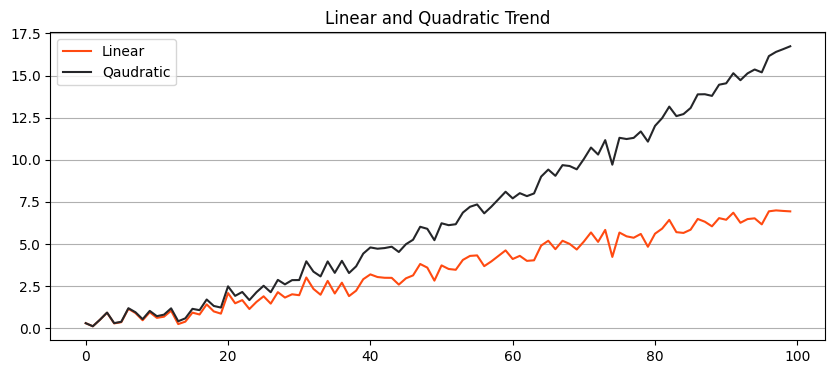

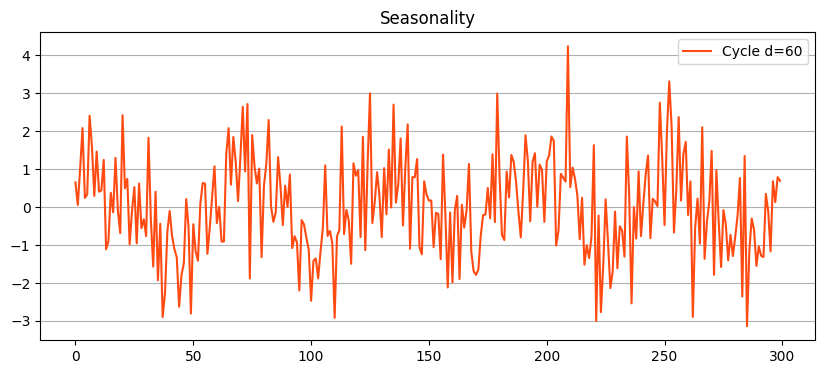

In [18]:
dpg_trend()
dpg_seasonality()

First thing is looking at the data and the missing values, then focusing on the movements in a time series. Specifically we’re focusing on trends and cycles.
Upper chart - Trend (long term information in the ts). makes ts non stationary -> need to detrend (seasonality remains). Some fluctuations, not a well defined mathematical function. 
Lower chart - Ratio of noise to data. Also seasonality.


### Trends
Trends are long-term information
* **Long-term tendency** of values
* Can show any **non-cyclical** behavior (linear, quadratic)

Difficulty from trends
* **Visualizing** short-/mid-term is masked)
* Modelling the values at different time intervals have different levels
* Distribution is time-dependent

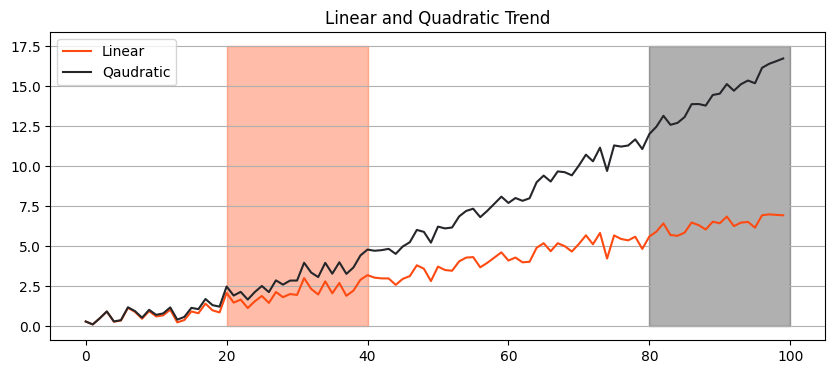

In [19]:
dpg_trend(fill=True, n_fill=2, fill_range=[[20,40],[80,100]], fill_range_y=[0,17.5])

Values in `x=[20-40]` have very different values from values in `x=[80-100]`

“Long term” - if you tell me where we are right now, I could tell you where we will be in 100 time units from now. 

In the chart the distribution of the values in a time series changes over time - hence non-stationary. Before we apply mathematical models for time series we have to make the time series stationary. We apply detrending for this purpose.   


### Eliminating trends

How to eliminate trends?
* Model + subtract trends
    * linear $ m_t = \alpha_0 + \alpha_1 t $
    * quadratic $ m_t = \alpha_0 + \alpha_1 t + \alpha_2 t^2 $
    
* Differencing $\Delta y_t = y_t - y_{t-1}$

* (High-Pass Filtering: e.g. Hodrick-Prescott)

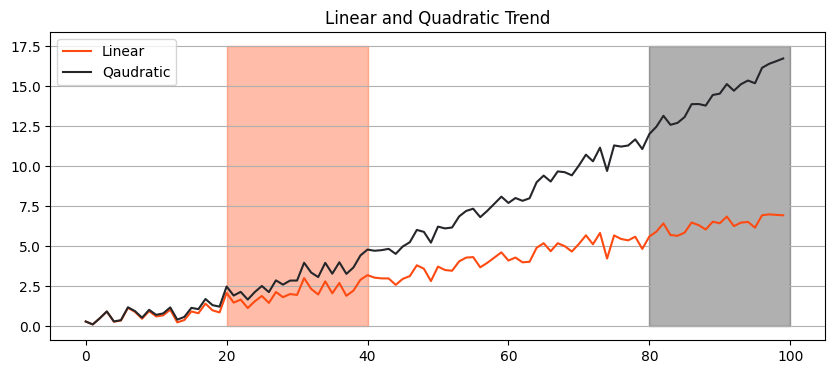

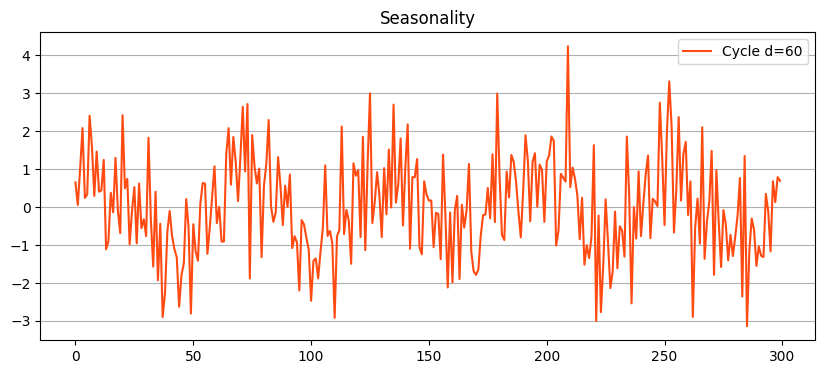

In [20]:
dpg_trend(fill=True, n_fill=2, fill_range=[[20,40],[80,100]], fill_range_y=[0,17.5])
dpg_seasonality()


Time series before and after eliminating the trend: afterwards short-/mid-term patterns are clearer

To detrend the time series - take the time series itself and subtract the model of the trend from it.
Might be difficult to do because it might be difficult to create a model for the trend - think 2 trends, stochastic trend etc. 
In this case we could use a filter. Eliminating some of the frequencies in a time series might help - “low pass” filter allows low frequency signals to pass. 
The trend being a long-term behaviour is a “low frequency” signal. So we need a high-pass (e.g. Hedrick-Prescott filter, or differencing) filter to detrend our data. The trend will not pass a high-pass filter (because high-pass doesn’t allow low-frequencies through) and we will have the chart above as a result. 


### Cycles - and on and on it goes

Seasonal patterns (cycles) are **mid-/short-term information**
* Recurring value levels
* Typical example: sales during the year
* Can show any cyclical behavior(e.g. Trigonometric)

Problematic in time series modeling
* Values in different areas of the cycle are significantly different
* Different distribution - **non-stationary**


<div class="alert alert-block alert-success"> <b>Question:</b> What are some seasonalities you can think of? </b></div>

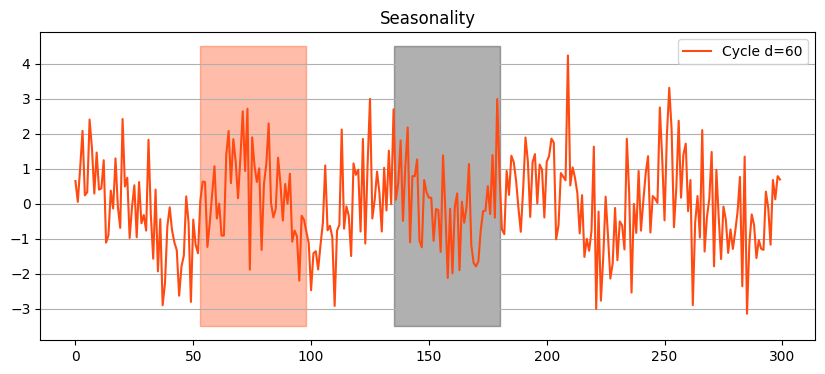

In [21]:
dpg_seasonality(fill=True, n_fill=2, fill_range=[[53,98],[135,180]], fill_range_y=[-3.5,4.5])

Value distributions look different at different time ranges

“Deseasonalising” means removing the season component from the data. Looking at “unemployment rate” for example makes sense if it has been deseasonalised as it allows for comparisons to previous time points. For example - more people are employed in June than in December, just due to seasonal effect, hence to compare we would need to deseason the data first. 
If we have seasonality the distribution also changes over time, hence we need to deseasonalise for being able to model.


### Eliminating cycles

<div class="group">
  <div class="text_70">
      
Cycles often contain process-intrinsic information

Eliminate cycles with
* Model + subtract trends
* Time differencing: $\Delta y_t = y_t - y_{t-4}$
* Low-pass filtering
* Fourier series: <br />
      $ s_t = \beta_0 + \sum_{j=1}^{k} (\beta_j \sin(\lambda_j t) + \kappa_j \cos(\lambda_j t))\text{, }\lambda_j = \frac{2\pi}{d_j} $

  </div>
  <div class="images_30">
      
<img src="../images/time_series_analysis_intro/img_p17_4.png">
      
  </div>
</div>



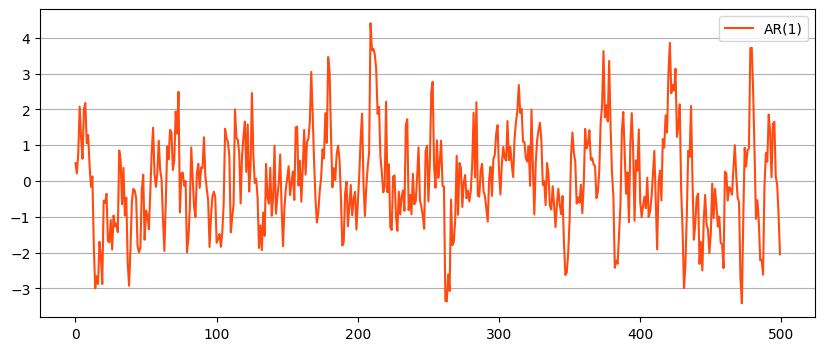

In [22]:
ar_1()

Time series before and after removing trend and seasonal patterns... what a beauty

Cycles are interesting because they demonstrate what time of the year is most important for our business. But the more important thing might be to see not what time is most important, but rather what are the time-independent changes. To see that we would need to eliminate the cycles. 
To eliminate the cycles we would need to understand how often is our time series at the same level. 
The frequency of the cycles is higher than that of the trend, hence to filter them out we would need a low-pass filter. 
Fourier series enables us to model the seasonality in our data that might contain multiple seasonal components. Fourier series is a way to approximate any cyclical signal. 
The chart demonstrates the data after we deseasonalise the data. 
detrended and deseasinalised data can still have a systematic part. e.g. autocorrelation this we can model. The remainder we are looking at still has autocorrelation and this is typical of a time series. 


## Recap:
We talked about timeseries data:
* Data were the sequence plays a crucial role
* Typically: data with a fixed interval without missing values

We talked about visual EDA:
* Trends (Where are they coming from? how to deal with that?)
* Cycles (Many examples, what to do with that?) 

## Special considerations in TSA

### Triggerwarning
#### Timeseries?
## DON'T PANIC


### Triggerwarning
#### Timeseries?
## ~~DON'T PANIC~~
## DON'T PANIC ... too much!
Working with time series data is harder than it seems.

Working with time series is different statistically from working with other types of data. 

Don't ever tell anyone your an expert in TSA unless you’re sure about it :D


## Common Tools in TSA

### Data

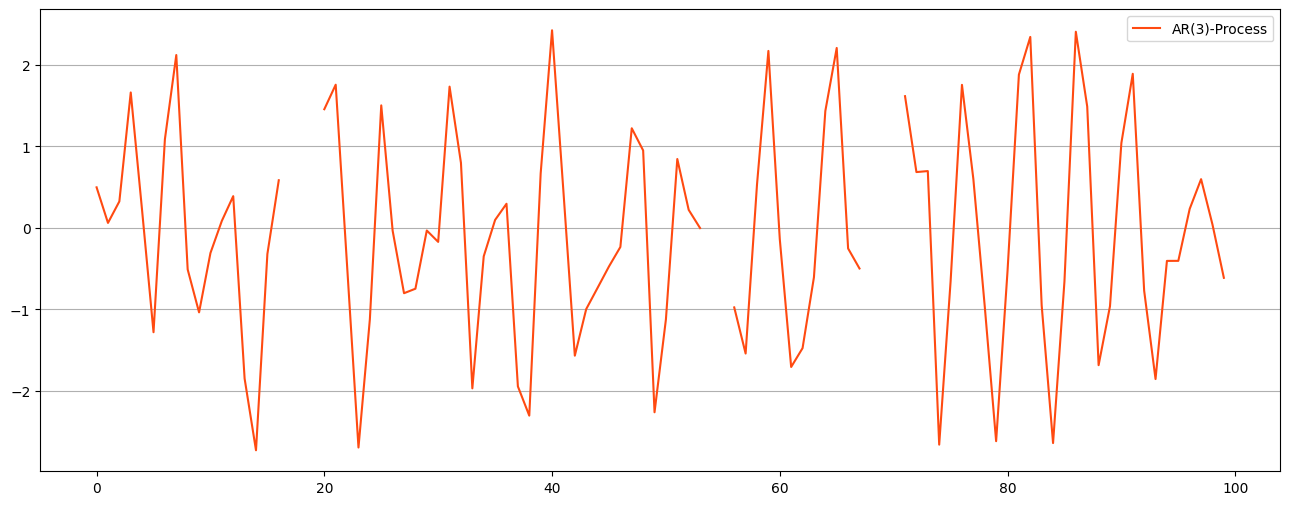

In [23]:
plot_ts_nan(y_acf_pacf, legend=['AR(3)-Process'], title='')

<div class="alert alert-block alert-info">
<b>Note:</b> 
There shouldn't be gaps in Timeseries data. And the
frequency should be consistent
</div>

First ask what is problematic with the shown data: The gaps.
Then ask them how they would impute values, to make it continuous
* Draw all the suggestions in different colors in the gaps
* when all suggestions are in, go to the next slide without deleting the drawing

Using the mean values, resampling or a more sophisticated model could help us fill in the gaps.


### Imputation

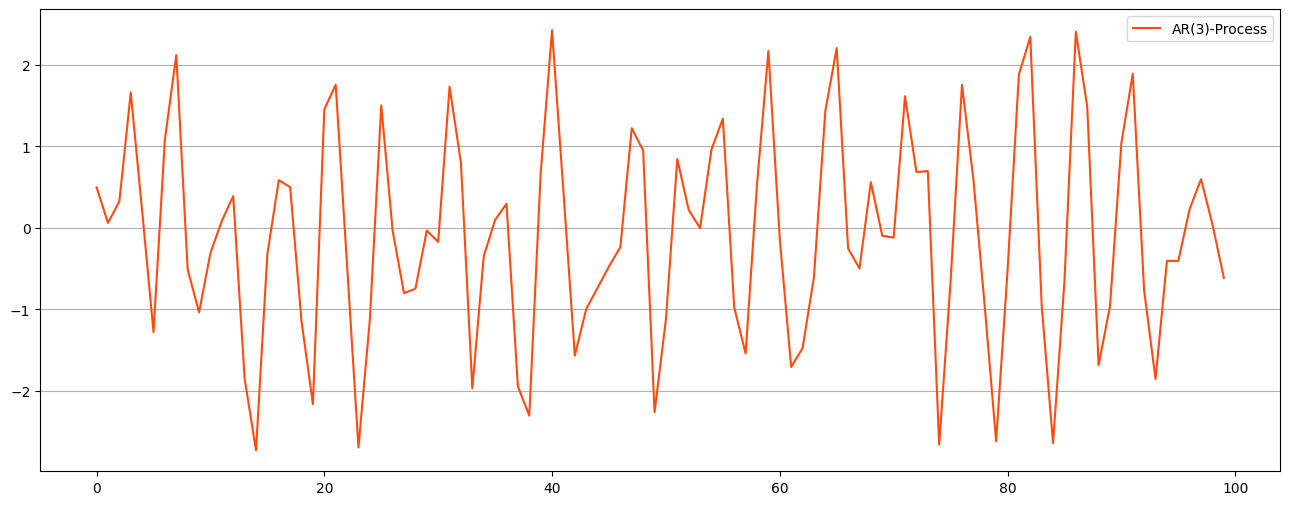

In [24]:
plot_ts(y_acf_pacf, legend=['AR(3)-Process'], title='', figsize=(16, 6))

1. filling (backfilll,forwardfill,mean)
2. interpolate / filtering
3. Resampling
4. Predicting

[pandas.Series.resample](https://pandas.pydata.org/docs/reference/api/pandas.Series.resample.html)

[DataFrame.fillna(value=None, method=None, axis=None, inplace=False, limit=None, downcast=None](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) <br />
method{‘backfill’, ‘bfill’, ‘pad’, ‘ffill’, None},

With the overlaping drawings from before, you can check if you got all of the ones discussed on the slide. if not, discuss them now.
Also, we can see that  even the more “complicated” ones we drew before are not showing the reality well -> hence it is still sensible to go for an easy method like ff or bf


### Train - Test - Split
**Q: How would you split a Timeseries?**

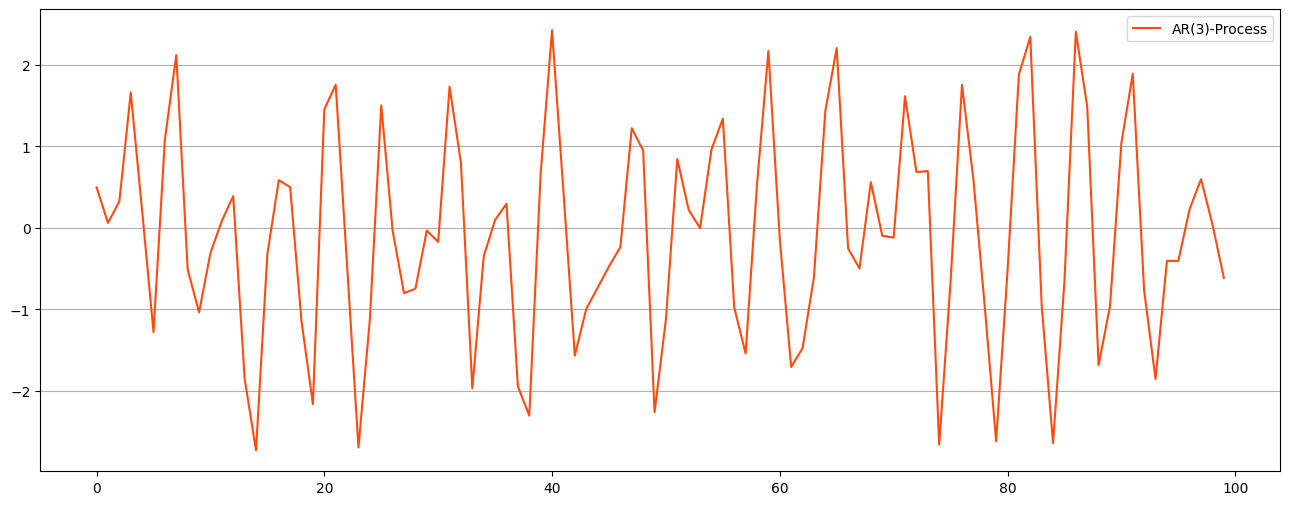

In [25]:
plot_ts(y_acf_pacf, legend=['AR(3)-Process'], title='', figsize=(16, 6))

First, ask them who the train test split is typically done (-> randomly).
Then ask, why that might be a problem in TSA (gaps, sequence)

Splitting the data randomly into train-validation-test might is not a good idea with time series because y at t depends on past y’s and random splitting would destroy that correlation. also you don’t want points in the future in train when trying to predict the future.


### Train - Test - Split
**Q: How would you split a Timeseries?**

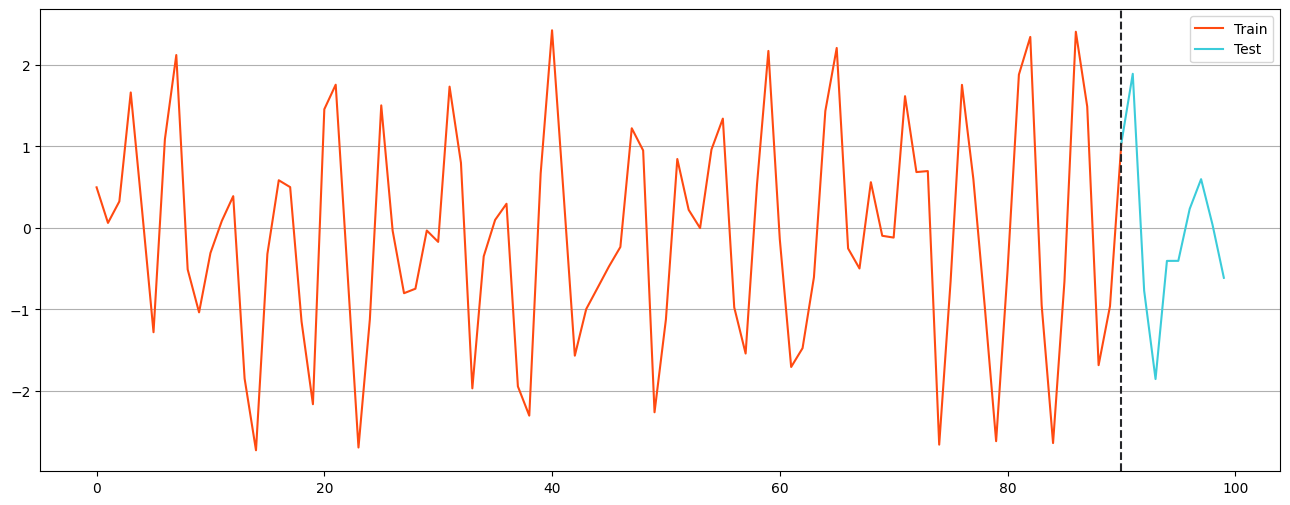

In [26]:
plot_ts_split(y_acf_pacf, legend=['Train','Test'], title='')

```python
train,test = data[:-10],data[-10:]
```

The “solution” is, to pick a timepoint and divide the data using a “before - after” approach. Leakage in time series is possible when a variable at a certain time point is used as a target variable in the train set and as a feature in the test set.

One way of overcoming this is leaving a gap between train and test, possible if we have enough data.  

### Crossvalidation

<div class="group">
  <div class="images">
      
<img src="../images/time_series_analysis_intro/img_p25_3.png">

  </div>
  <div class="images">
      
<img src="../images/time_series_analysis_intro/img_p25_4.png">
      
  </div>
</div>

[Cross validation in TSA](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4)

[CV in Timeseries 2](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)

Different ways of cross validation are possible in TSA. Two simple ones are shown here. Problem with the left one is, that the amount of training data differs between the CV iterations.-> it is expected that the first one has a higher (variance) error than the last one.

Something that is done is:
1. Define the business case how a model is used (“every sunday we retrain a model to predict the next week”) 
2. To evaluate the performance of a model, the model is used as defined in 1: the model is retrained every week (on training data!) and a prediction is made for the next week. Then the next weeks actual data is added to the models training data and its retrained -> afterwards we get a prediction for the next couple of days. At the end, you can put together all the weekly predictions the different(ly trained models) generate. That allows to make a better evaluation of the practical performance than if you just randomly pick some points.


### Stationarity

<img src="../images/time_series_analysis_intro/ts_stationary_mean_std.png">

Non-stationarity is / can be a problem in TSA (-> some models can deal with it well, others not at all).
The easiest way to check if non-stationarity are present is to randomly choose two ranges (shown in red here) and compare if both have the same mean and standard deviation. This should be true for (almost) all chosen range-pairs.

There are also a more scientific tests…. (next slide)


### What does it mean for a TS to be stationary?

Having a constant mean and covariance function across the time series - **in short:** constant moments

A time series needs to be stationary in order to make good predictions

How do we know?
* **ADF** test - Null Hypothesis: Not Stationary
* **KPSS** test - Null Hypothesis: Stationary

We can also look at the **autocorrelation function ACF**

Strong stationarity - all co-joint distributions of the time series are constant.
Weak stationarity - constant statistical moments (mean, variance, skewness …)

The tests that can be applied to test for stationarity are : 
Augmented Dickey Fuller
Kwiatkowski–Phillips–Schmidt–Shin

What if the tests don’t agree? Check if they actually disagree (different null hypothesis!) and if they do: choose the less favorable option

The procedure would be to run the test, remove non-stationary components and then run the test again. Repeat until the time series is stationary. 


### Rolling Mean

**Carefull:** This rolling mean is actually an AR(p) process, not a MA(q)

In [27]:
Video("../images/time_series_analysis_intro/unif.mp4")

Start by asking who has worked with rolling mean / moving average / (many different names for the same thing) before and can give some examples where and why.

Show and discuss animation. Show the windowing function (always the last 9 values are used). Discuss the “normal” mean (all weights are 1/9 or 11,1% )
show how it smoothes out some of the variance
show how it always lags behind.
discuss how this could look like with a symmetric window and how that could be used e.g. for imputations

Moving average is a type of a filter - it’s a smoother. 


### Exponential Smoothing Methods

In [28]:
Video("../images/time_series_analysis_intro/exp.mp4")

Explain how the window here always expands (past is not forgotten!) but how the impact from past events gets smaller and smaller
Explain how the coefficient determines whether more weight is put on recent or past events.

Explain (if ppl care) why this is very efficient to compute, because people tend to think that you need to sum up all past values * weight. When you actually only have to to this for two values (recursiveness!) $\text{emwa}_t=\alpha*x_t+\text{emwa}_{t-1}*(1-\alpha)$


## Modelling Time Series

## The oldschool stuff - Decomposition

### What makes a time series?

A simple additive decomposed model

$$x_t = m_t + s_t + e_t$$

* $m_t$ is the trend 
* $s_t$ is the seasonality
* $e_t$ is the error or random noise

**Trend** -> increase or decrease of the values in the series

**Seasonality** -> the repeating short term cycles in the series

**Random noise** -> random variation in the series though there might also be some autocorrelations that can be discovered?!

### Additive vs Multiplicative

<div class="group">
  <div class="images">
      
<center><img src="../images/time_series_analysis_intro/img_p36_1.png" width="150"></center>
    
  </div>
  <div class="images">
          
<center><img src="../images/time_series_analysis_intro/img_p37_2.png" width="150"></center>
      
  </div>
</div>


You can draw now both options, ideally giving first the components (trend + seasonality) and then the sum.
-> afterwards you can go to the next slide to showcase a comparison of “real” data

<center><img src="../images/time_series_analysis_intro/img_p39_3.png"></center>

Mutliplicative seasonality is typically seen as something ‘Exploding’ - chart on the right the oscillations become larger and larger. An example equation of such a time series would be $X_t = M_t*S_t*E_t$ rather than $X_t = M_t + S_t + E_t$ for additive seasonality

## Components of TS

### Signal
Temperature measurements in Basel


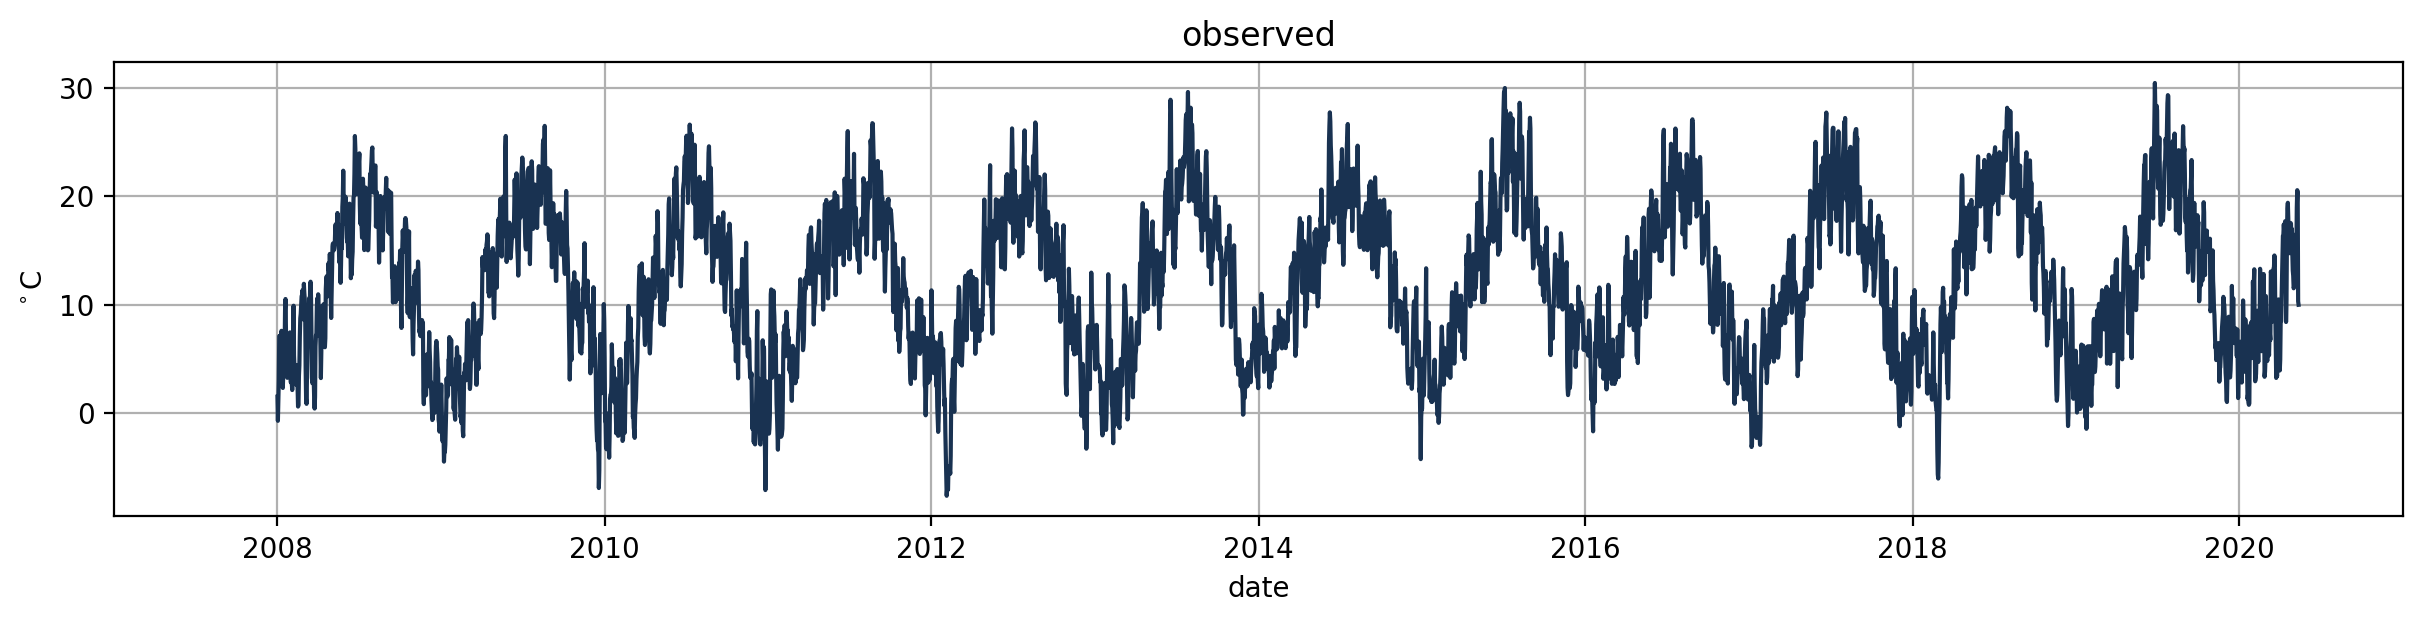

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=200, constrained_layout=True)
seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax)
ax.set(title='observed', ylabel=r'$^\circ$C');
plt.xlim(datetime.date(2007, 1, 1), datetime.date(2021, 1, 1))
plt.grid()

### Trend
What does the trend look like for the temperatures?
* (strong) upward trend
* temperature is gradually rising

<div class="alert alert-block alert-info">
<b>Note:</b> 
The trend is computed based on the moving average
</div>


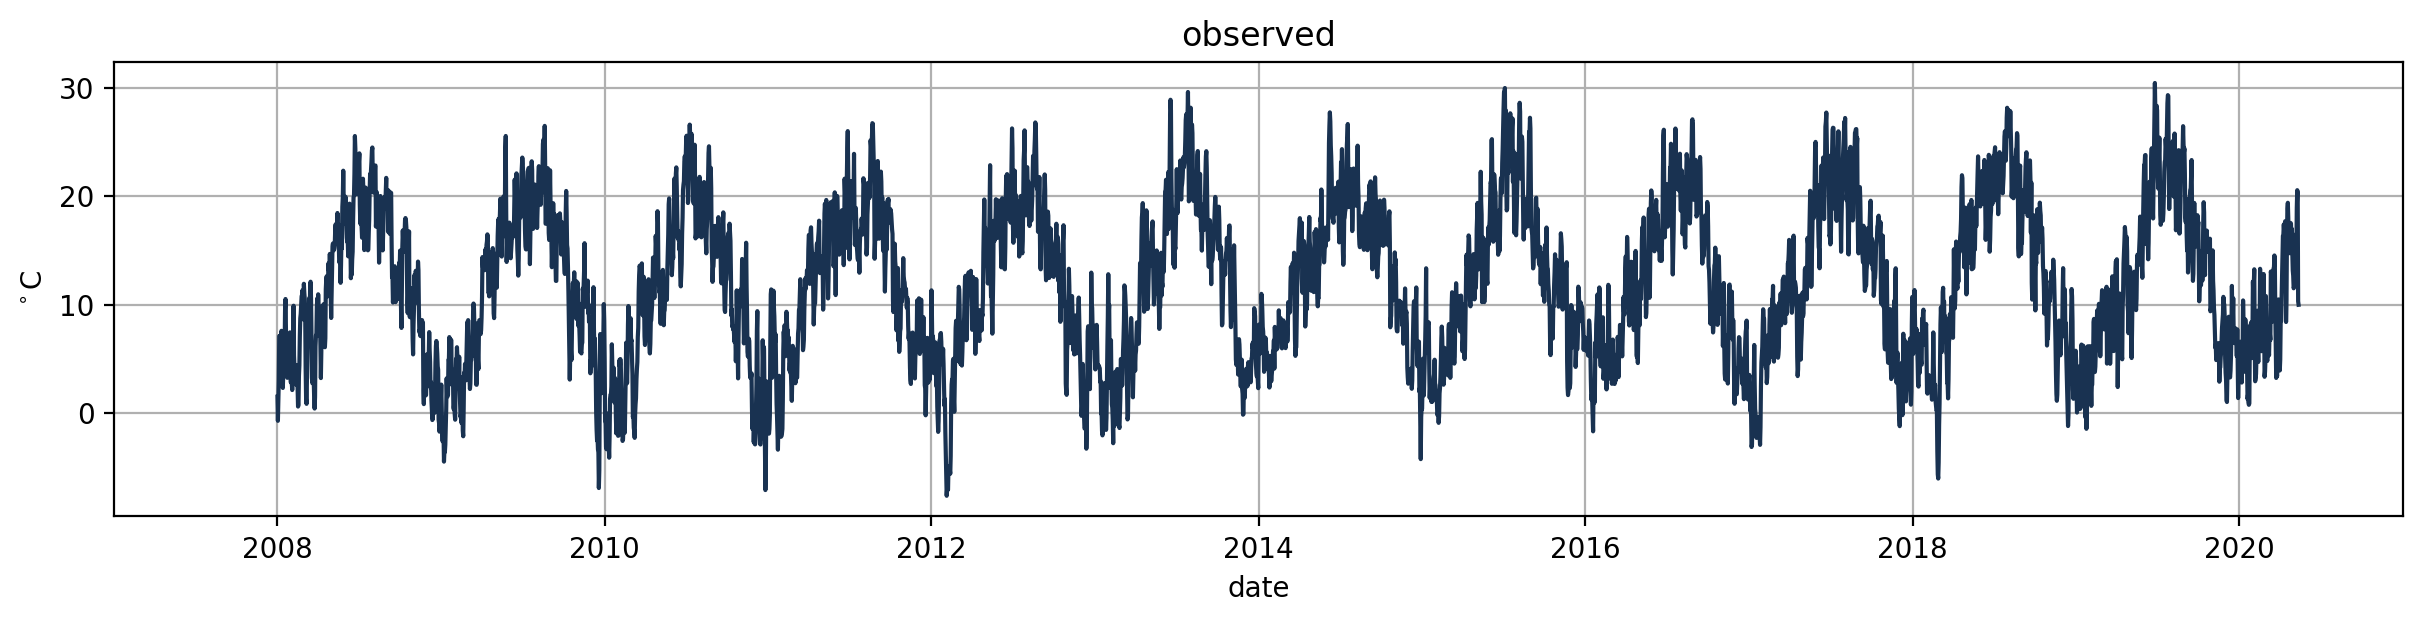

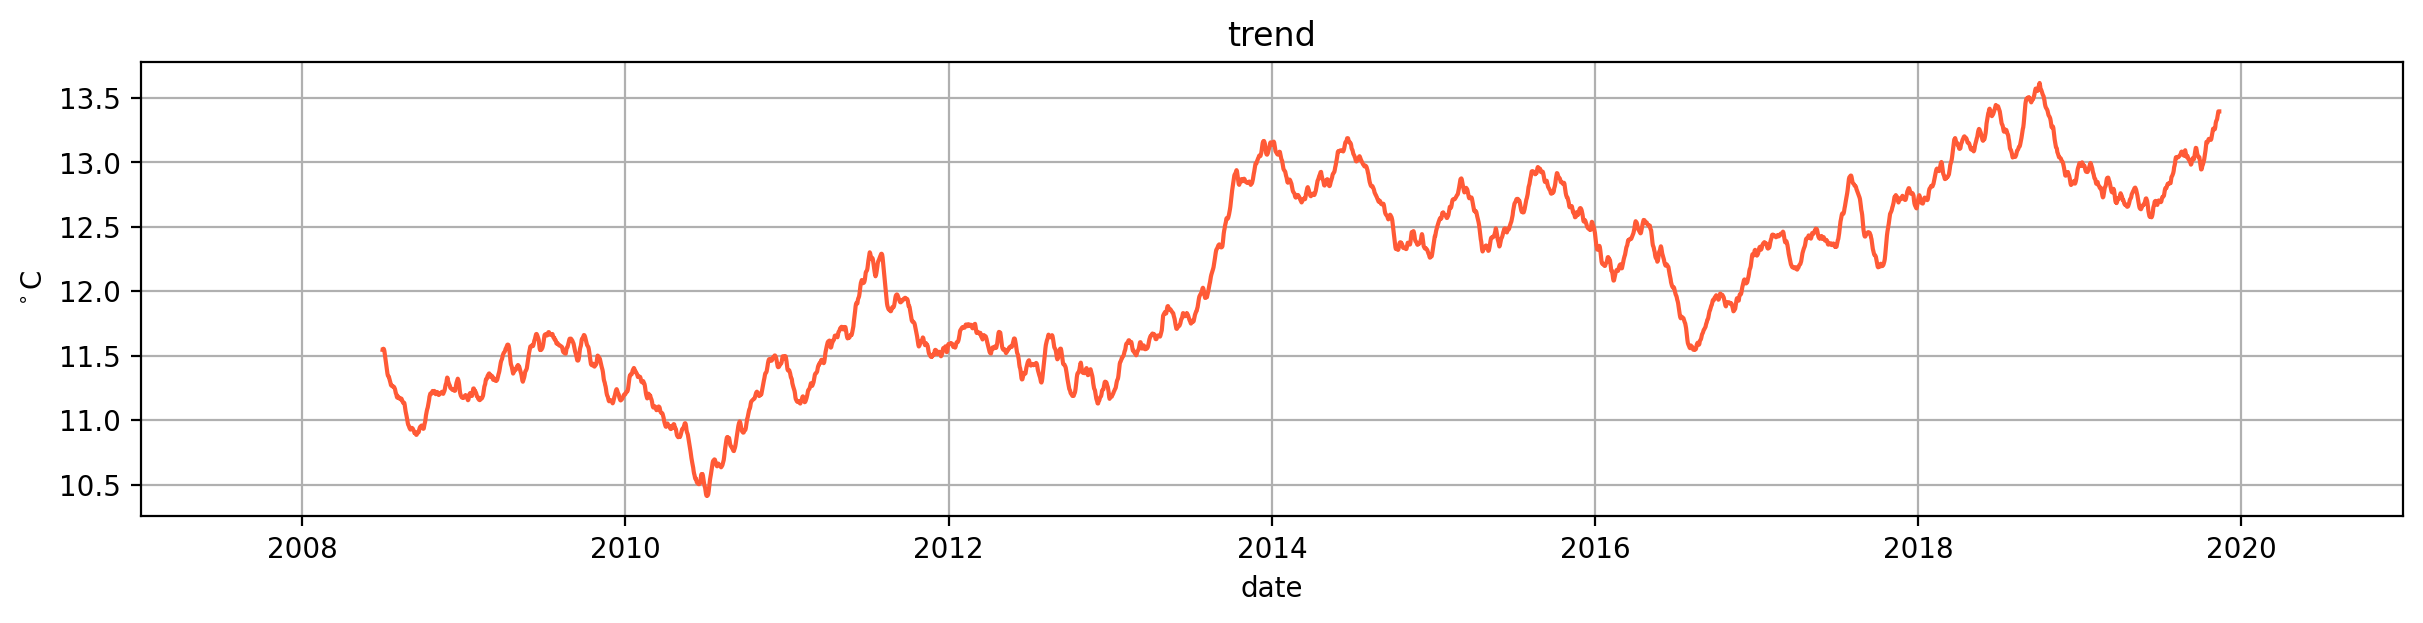

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=200, constrained_layout=True)
seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax)
ax.set(title='observed', ylabel=r'$^\circ$C');
plt.xlim(datetime.date(2007, 1, 1), datetime.date(2021, 1, 1))
plt.grid()

fig, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=200, constrained_layout=True)
seas_decomp_yearly.trend.plot(c=sns_c[1], ax=ax)
ax.set(title='trend', ylabel=r'$^\circ$C');
plt.xlim(datetime.date(2007, 1, 1), datetime.date(2021, 1, 1))
plt.grid()

How is the trend computed? A moving average as shown in the animation earlier.
Here we gave the algorithm the info that we are interested in a year-long seasonality (i.e. 365 days). That length is used as a centered window.
(if you look carefully at the trend line: compared to the observed data it starts exactly half a day later)

You can show the difference in range (-5°C - +30°C =35°C vs ~3°C) -> zoom in / zoom out effect


### Seasonality
What does the seasonality look like for the temperatures?
* We see a strong seasonality for summer and winter
* in business cycles we have the problem of very long cycles - so very long persistence

<div class="alert alert-block alert-info">
<b>Note:</b> 
The seasonality is the mean of the seasonal periods
</div>



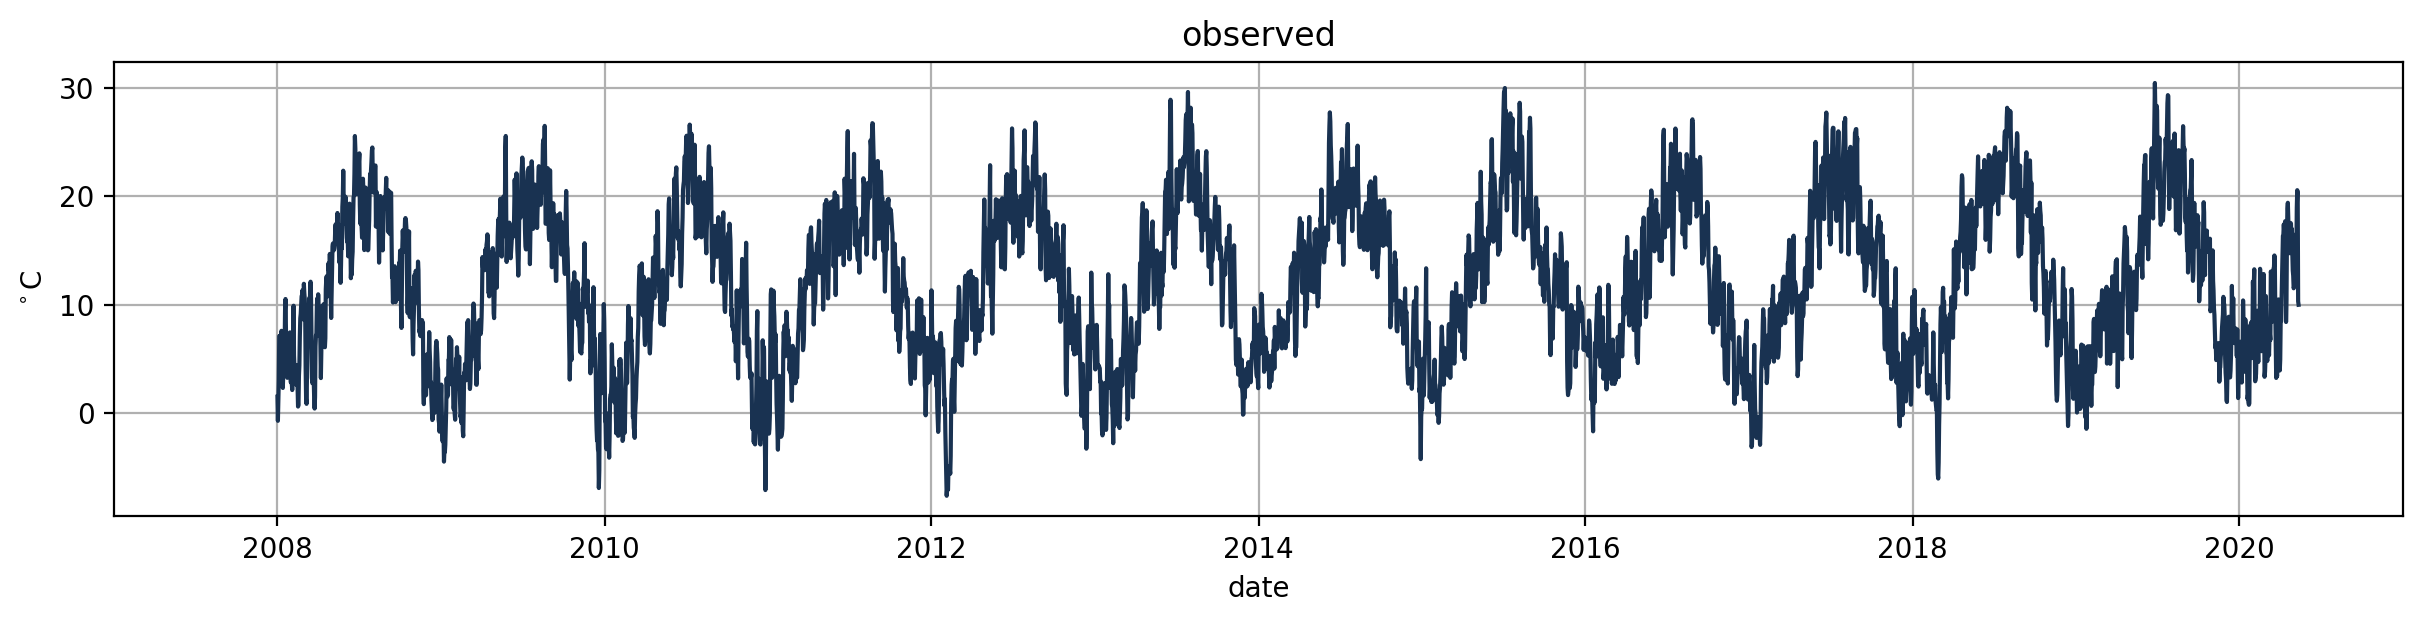

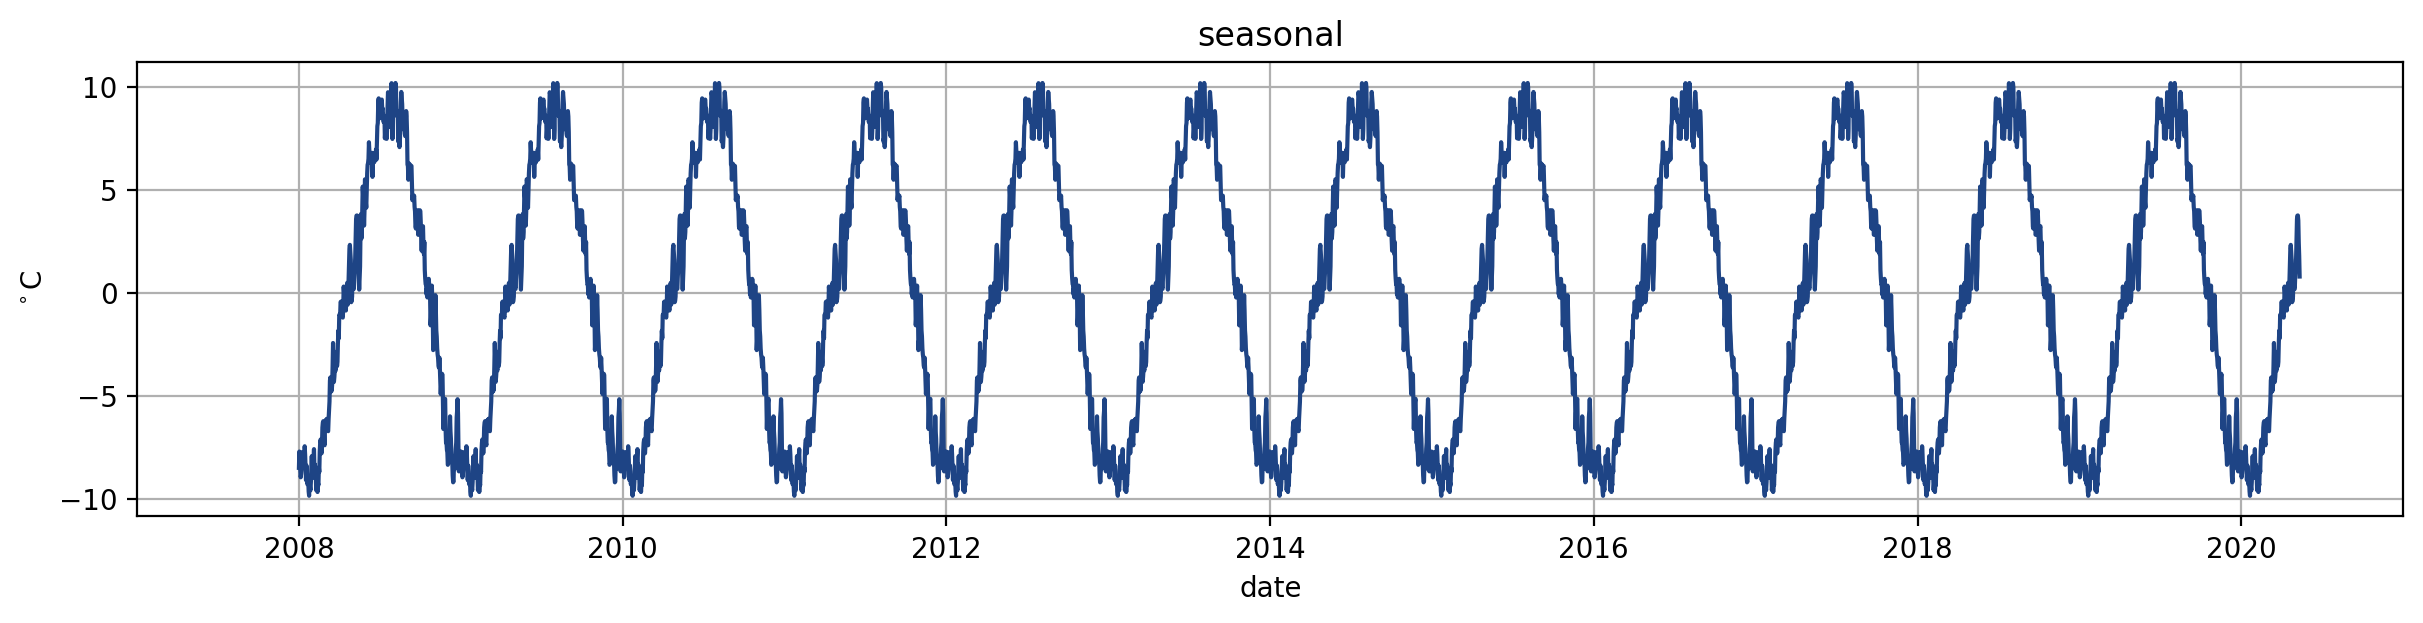

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=200, constrained_layout=True)
seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax)
ax.set(title='observed', ylabel=r'$^\circ$C');
plt.xlim(datetime.date(2007, 1, 1), datetime.date(2021, 1, 1))
plt.grid()

fig, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=200, constrained_layout=True)
seas_decomp_yearly.seasonal.plot(c=sns_c[2], ax=ax)
ax.set(title='seasonal', ylabel=r'$^\circ$C');
plt.xlim(datetime.date(2007, 1, 1), datetime.date(2021, 1, 1))
plt.grid()

I.e. the trend is removed from the data and the average over the seasons is shown (eg. take all the first point for each season and average over them)

For the first value of the seasonal line, (i.e. 1.1.2008) all “first of january” values from the data are selected and there mean is chosen and selected as the value for the seasonal line for every 1.1 (each year!). This is then done for the 2. (2.1.2008) and so on. 
Hence, as the pattern repeats after a year, it is exactly the same pattern over and over -> and can easily be generated for future values as well)

### Residuals
We want residuals to look random
* it is random looking
* it shows the variation in the series
* unexplained variance happening due to chance

<div class="alert alert-block alert-info">
<b>Note:</b> 
The Residual is what remains after removing trend and seasonality.
</div>

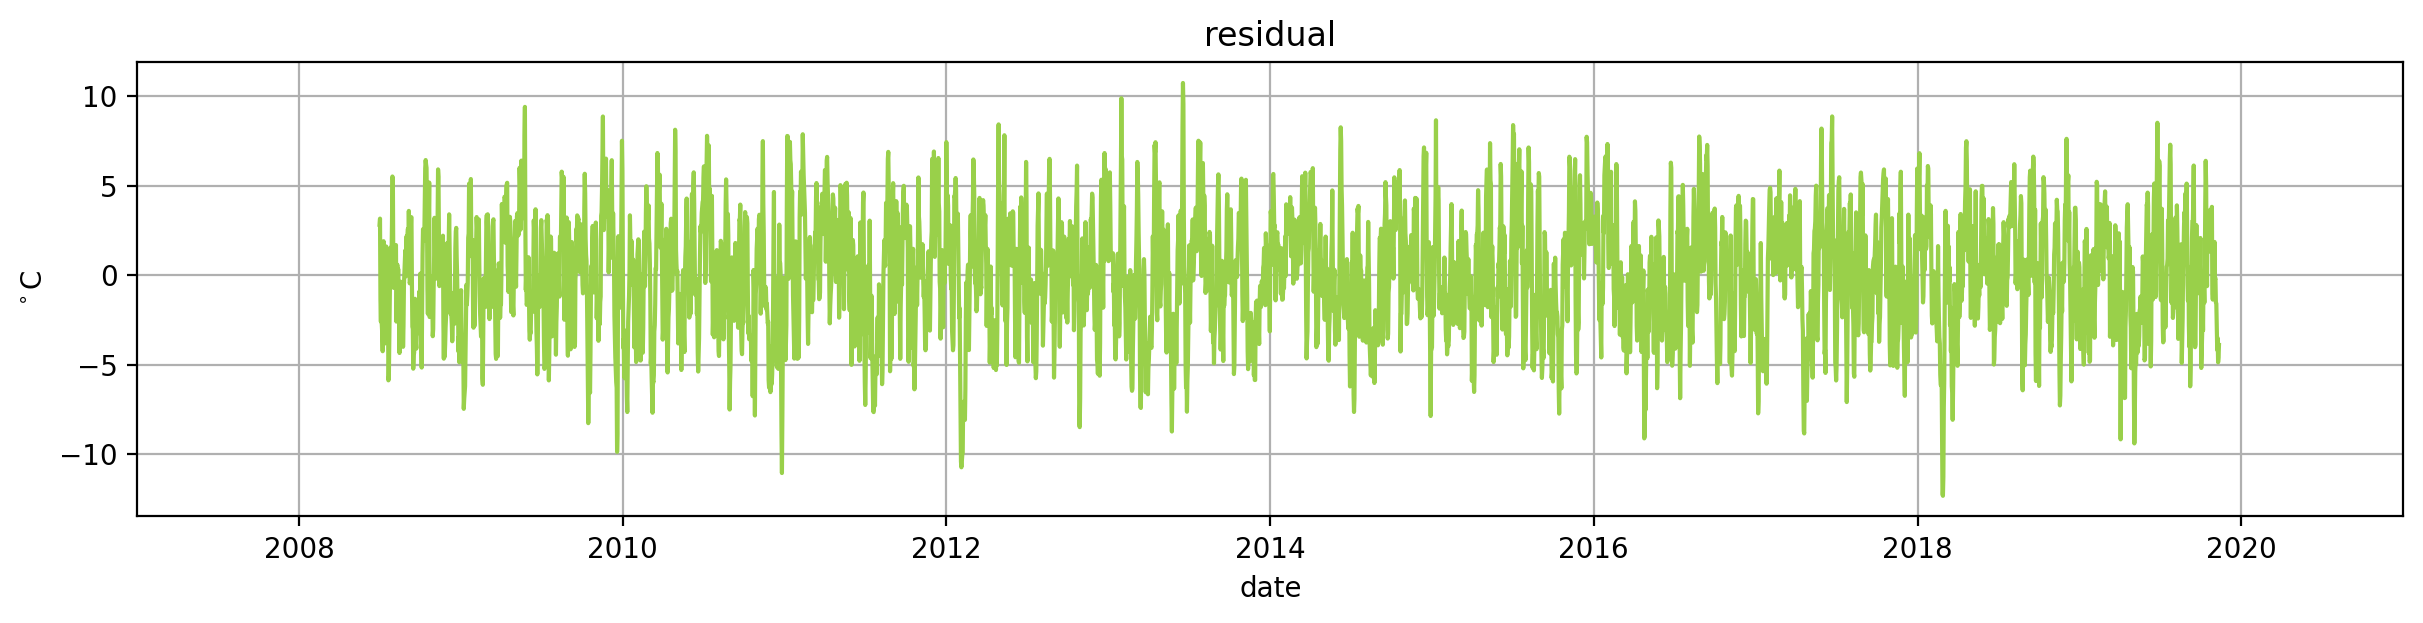

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=200, constrained_layout=True)
seas_decomp_yearly.resid.plot(c=sns_c[3], ax=ax)
ax.set(title='residual', ylabel=r'$^\circ$C');
plt.xlim(datetime.date(2007, 1, 1), datetime.date(2021, 1, 1))
plt.grid()

The residuals are the rest -> so that if you compute the observed, minus trend and seasonality what remains is the residual.
This should be checked for patterns (some are still in there!)
If there are still patterns there, this could be a good starting point for another Time series analysis (in this case an arma model in a couple of slides) could work.

Modelling the residual is what we concentrate on in classical time series. 


### Components of TS


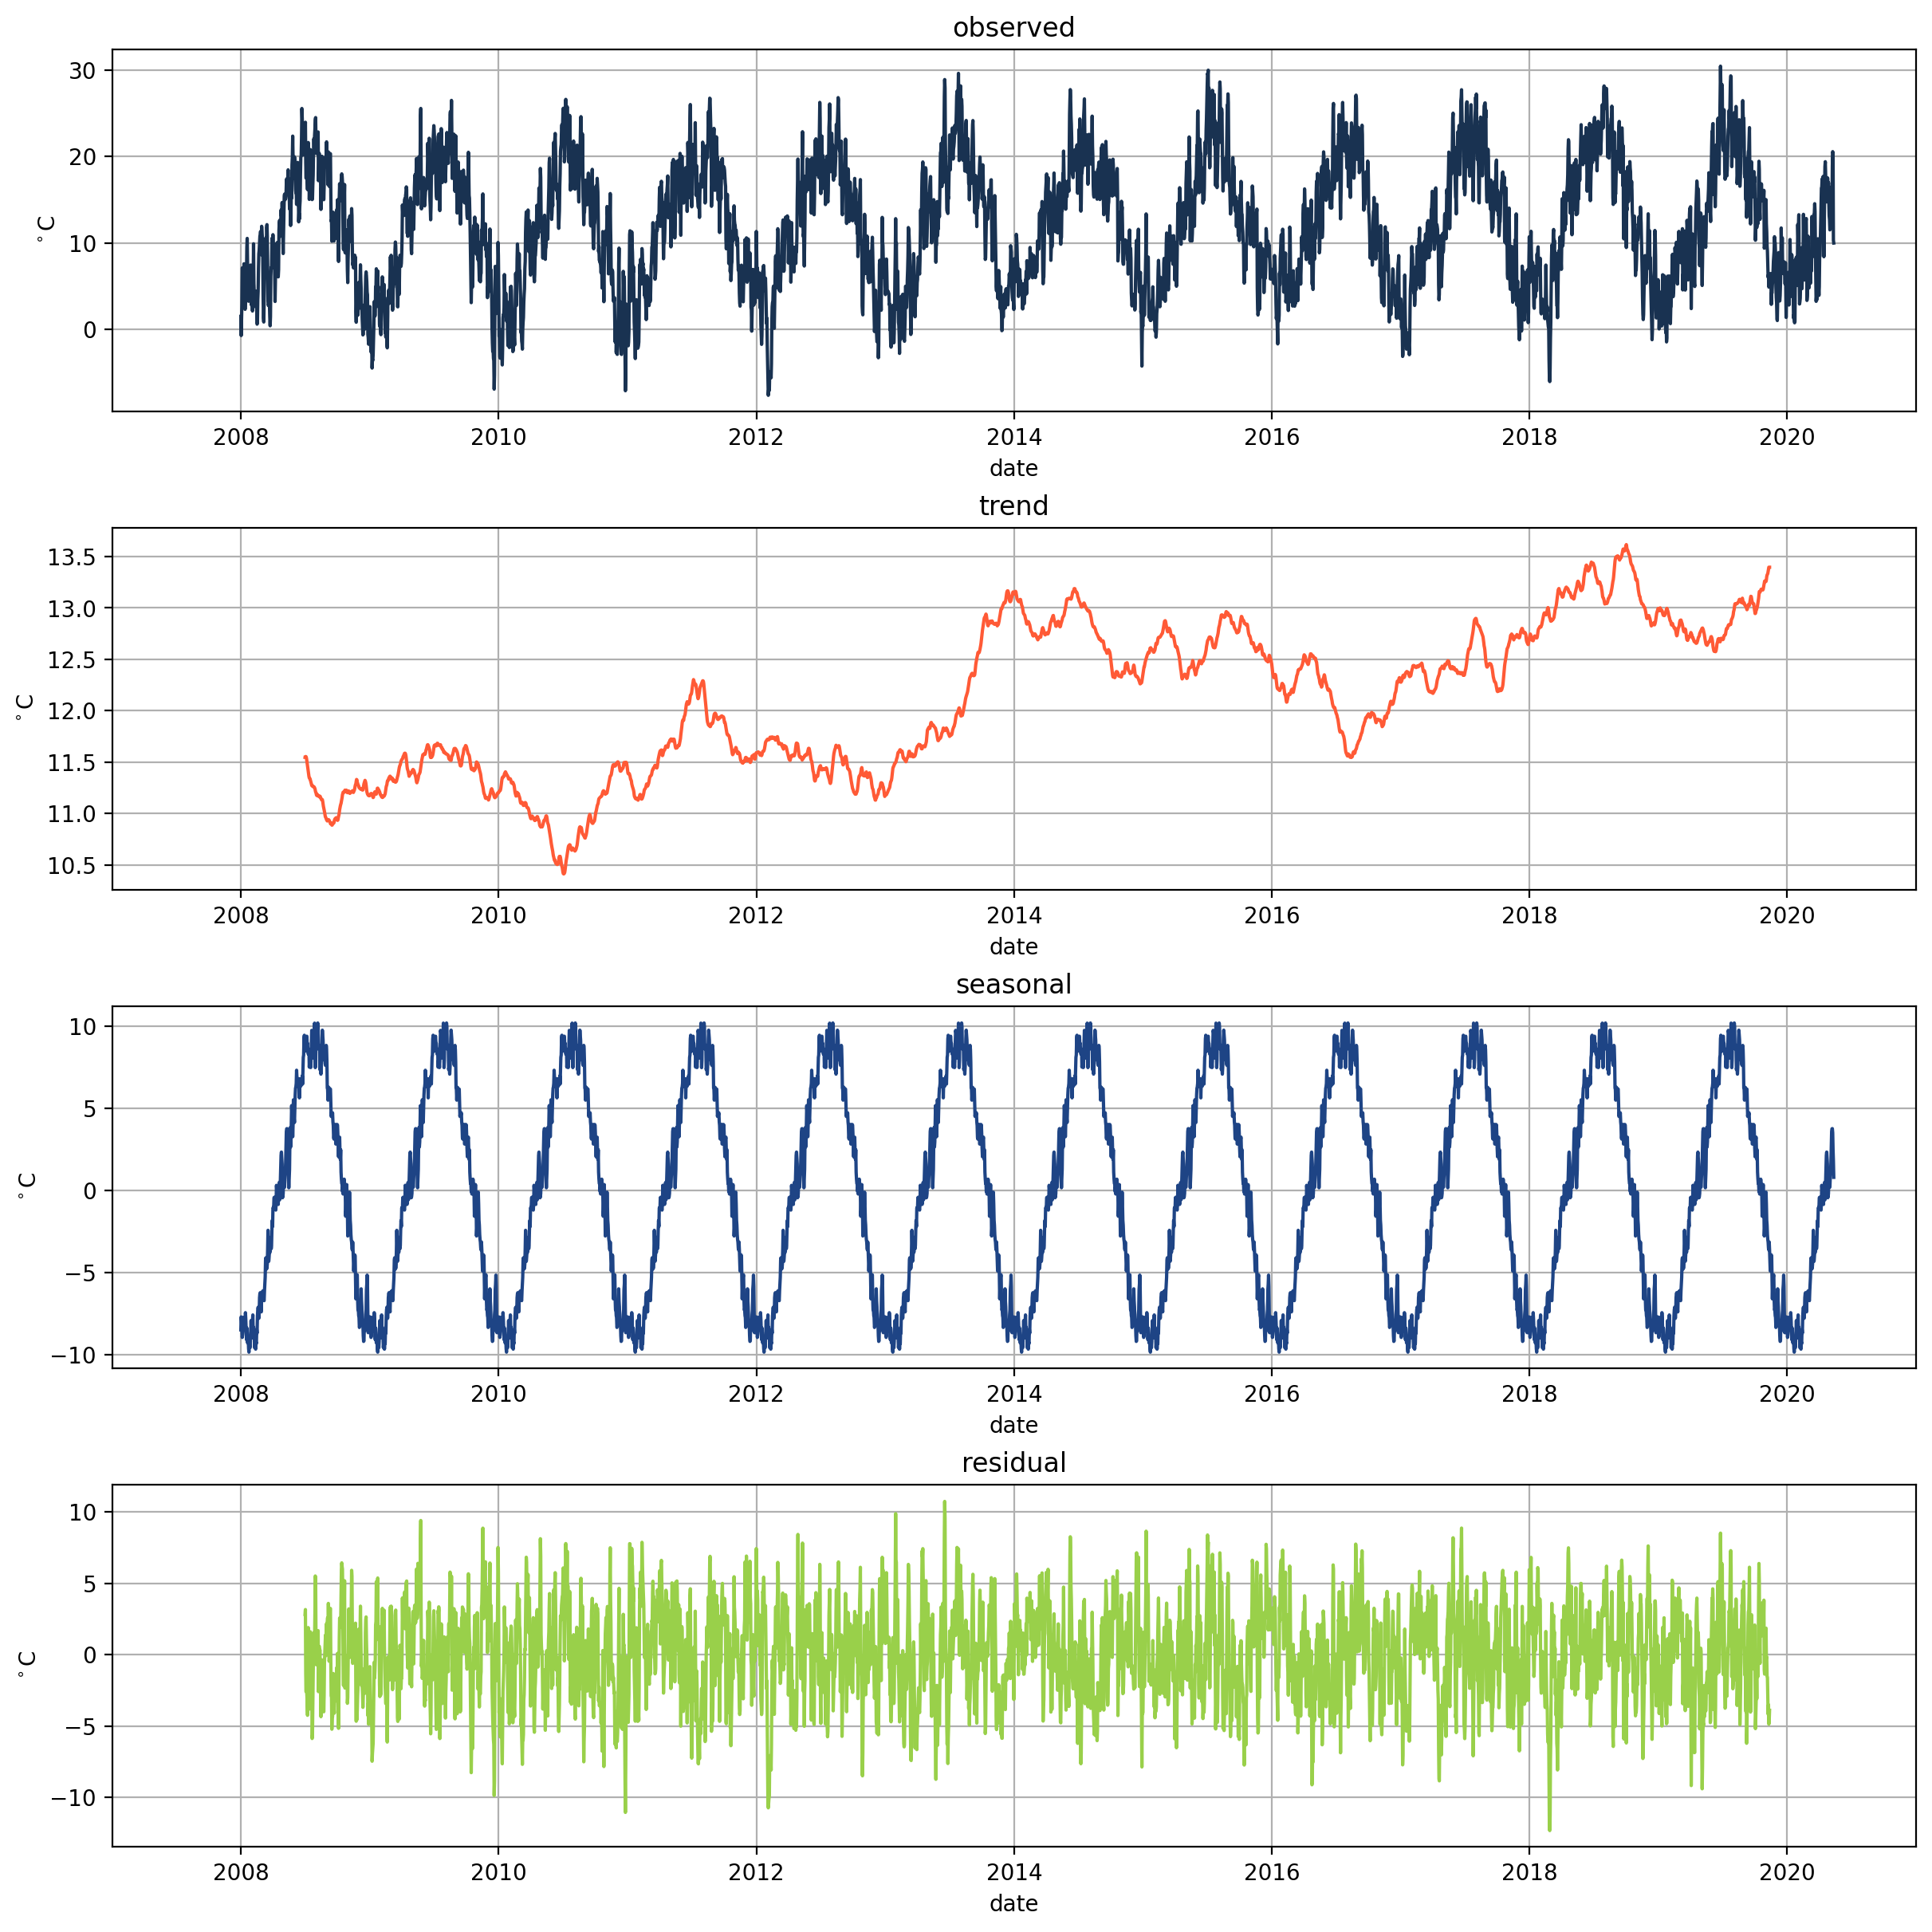

In [33]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12), dpi=200, constrained_layout=True)
seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel=r'$^\circ$C')
seas_decomp_yearly.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel=r'$^\circ$C')
seas_decomp_yearly.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel=r'$^\circ$C')
seas_decomp_yearly.resid.plot(style='-',c=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel=r'$^\circ$C');

for i in range(4):
    ax[i].set_xlim(datetime.date(2007, 1, 1), datetime.date(2021, 1, 1))
    ax[i].grid()

## The oldschool stuff - ARMA


### It's getting serious. Let's talk cakes!

<img src="../images/time_series_analysis_intro/cake.png">



### Data Generating ARMA process example



<div class="text_30">
<div class="box1_store">
    
&nbsp; **Store**
    
&nbsp; Current stock of cake <span style="font-size:50px">$\hspace{0.5cm}X_t$</span>
          
</div>


<div class="box2_production">
    
&nbsp; **Production**
          
&nbsp; About 100 cakes are produced every day <span style="font-size:50px">$\hspace{2cm}\varepsilon_t$</span> <br />
&nbsp; (normally distributed)
    
</div>

<div class="box3_thieves">
    
&nbsp; **Thieves!**
          
&nbsp; 15% of the cakes from stock <br />
&nbsp; are eaten by Larissa
</div>


<div class="box4_sales1">
    
&nbsp; **Sales**
          
&nbsp; 40% of the production are picked up <br />
&nbsp; the next day 
</div>
    

<div class="box5_sales2">
 
<br/>   <br/> 
&nbsp; 20% of the production are picked up <br />
&nbsp; the day after
</div>
    
<div class="box6_cake_image_equation">
<img src="../images/time_series_analysis_intro/cake.png">
</div>

</div> 




Say you own a nice little business: a cake storage company. You have a nice storage room, the local bakery brings you their cakes and people (their customers) collect them shortly afterwards.
On an average day, the bakery bakes about 100 cakes. Sometimes this is a little more, sometimes a little less. We assume it to be normally distributed with a mean of 100.
Every day, the bakery sells 40% of their stock to “quick customers” who come to pick it up already the next day. Another 20% is sold to “lazy customers” who only pick it up after two days. 
Unfortunately, we don’t really like he bakery. And they also don’t like us. It stands to reason that we dont communicate with each others. They don’t tell us how many cakes they bake, or sell on any given day.
As we don’t talk to the bakery, obviously we don’t know how many cakes are sold, or are going to be picked up. We also don’t talk to the customers on pickup, so we don’t know if they are of the “lazy” or “quick” variety either.
So far so good… well almost. Every night, Larissa (sometimes with friends) sneaks in to eat some cake. some, as in exactly 15% of every thing that is in stock.

This is the story that we first want to turn into an equation, and later into a model. 


Ask if everyone understood the story (it’s not relevant how this connects to DS yet) 


### Data Generating ARMA process example

<div class="text_30">
<div class="box1_store">
    
&nbsp; **Store**
    
&nbsp; Current stock of cake <span style="font-size:50px">$\hspace{0.5cm}X_t$</span>
          
</div>


<div class="box2_production">
    
&nbsp; **Production**
          
&nbsp; About 100 cakes are produced every day <span style="font-size:50px">$\hspace{2cm}\varepsilon_t$</span> <br />
&nbsp; (normally distributed)
    
</div>

<div class="box3_thieves">
    
&nbsp; **Thieves!**
          
&nbsp; 15% of the cakes from stock <br />
&nbsp; are eaten by Larissa
</div>


<div class="box4_sales1">
    
&nbsp; **Sales**
          
&nbsp; 40% of the production are picked up <br />
&nbsp; the next day 
</div>
    

<div class="box5_sales2">
 
<br/>   <br/> 
&nbsp; 20% of the production are picked up <br />
&nbsp; the day after
</div>


Develop formula for Xt together with students  and write it down below (see next page).
The idea here is to make sure every one understands where 
* the numbers come from.
* Make sure people get used to the “t-1 / t-2” notation for timesteps.
Once you managed to write down the complete formula, go to the next slide to see a “easier readable” version




<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br />
<span style="font-size:50px">$X_t = \underbrace{0.85 X_{t-1}}_{\text{AR(1)}} \underbrace{- 0.2\varepsilon_{t-2} - 0.4\varepsilon_{t-1}}_{\text{MA(2)}} + \varepsilon_t$</span> 






https://latex.codecogs.com/png.latex?\dpi{300}&space;\large&space;X_t=0.85&space;X_{t-1}-0.2\varepsilon_{t-2}-0.4\varepsilon_{t-1}&plus;\varepsilon_t

On this slide, it’s important to discuss the formula again, and thoroughly.
There are different ways to look at the individual parts of the formula:
present vs past: everything t-1 or older has happened already. We might not know it (epsilon) but it is fixed. everything t or newer is “not yet decided”
We can also divide the formula into things that use X as a variable (X is “our” variable. its in our store so we can measure it) and things that use epsilon (that is “their” variable. The bakery could measure it, but for us this is value that we can’t measure)
The part of the equation that depends on X is the AR (Auto-regressive) part of the process. The part that uses Epsillon is the MA(Moving average) part of the process. Hence, here we have a combined AR-MA process.
If we want to describe this further, we can look which is the “oldest” value each of the processes use: the AR process is based on Xt-1 (1 lag) so we can call it a AR(1) process. the MA process has as the oldest value a epsilon t-2 (2lags) so it’s an MA(2) process. The number (order of the process) does not mean that the process is using 1 term, but that the oldest term is on lag 1.

e.g. the model Xt=0.5Xt-5 +e would be an AR(5) process even though it using only on term.

Ther last term in the equation epsilon t is special for this problem. On the one hand, this term (how many cakes are produced each day) is the one term that brings in the innovation, that drives the whole process (hence, its sometimes called source, or innovation term). On the other hand, it’s the term that we don’t know anything about, and that is totally governed by chance (in theory at least). This is also the part that we are missing when we make predictions -> the residual


### Data Generating ARMA process example

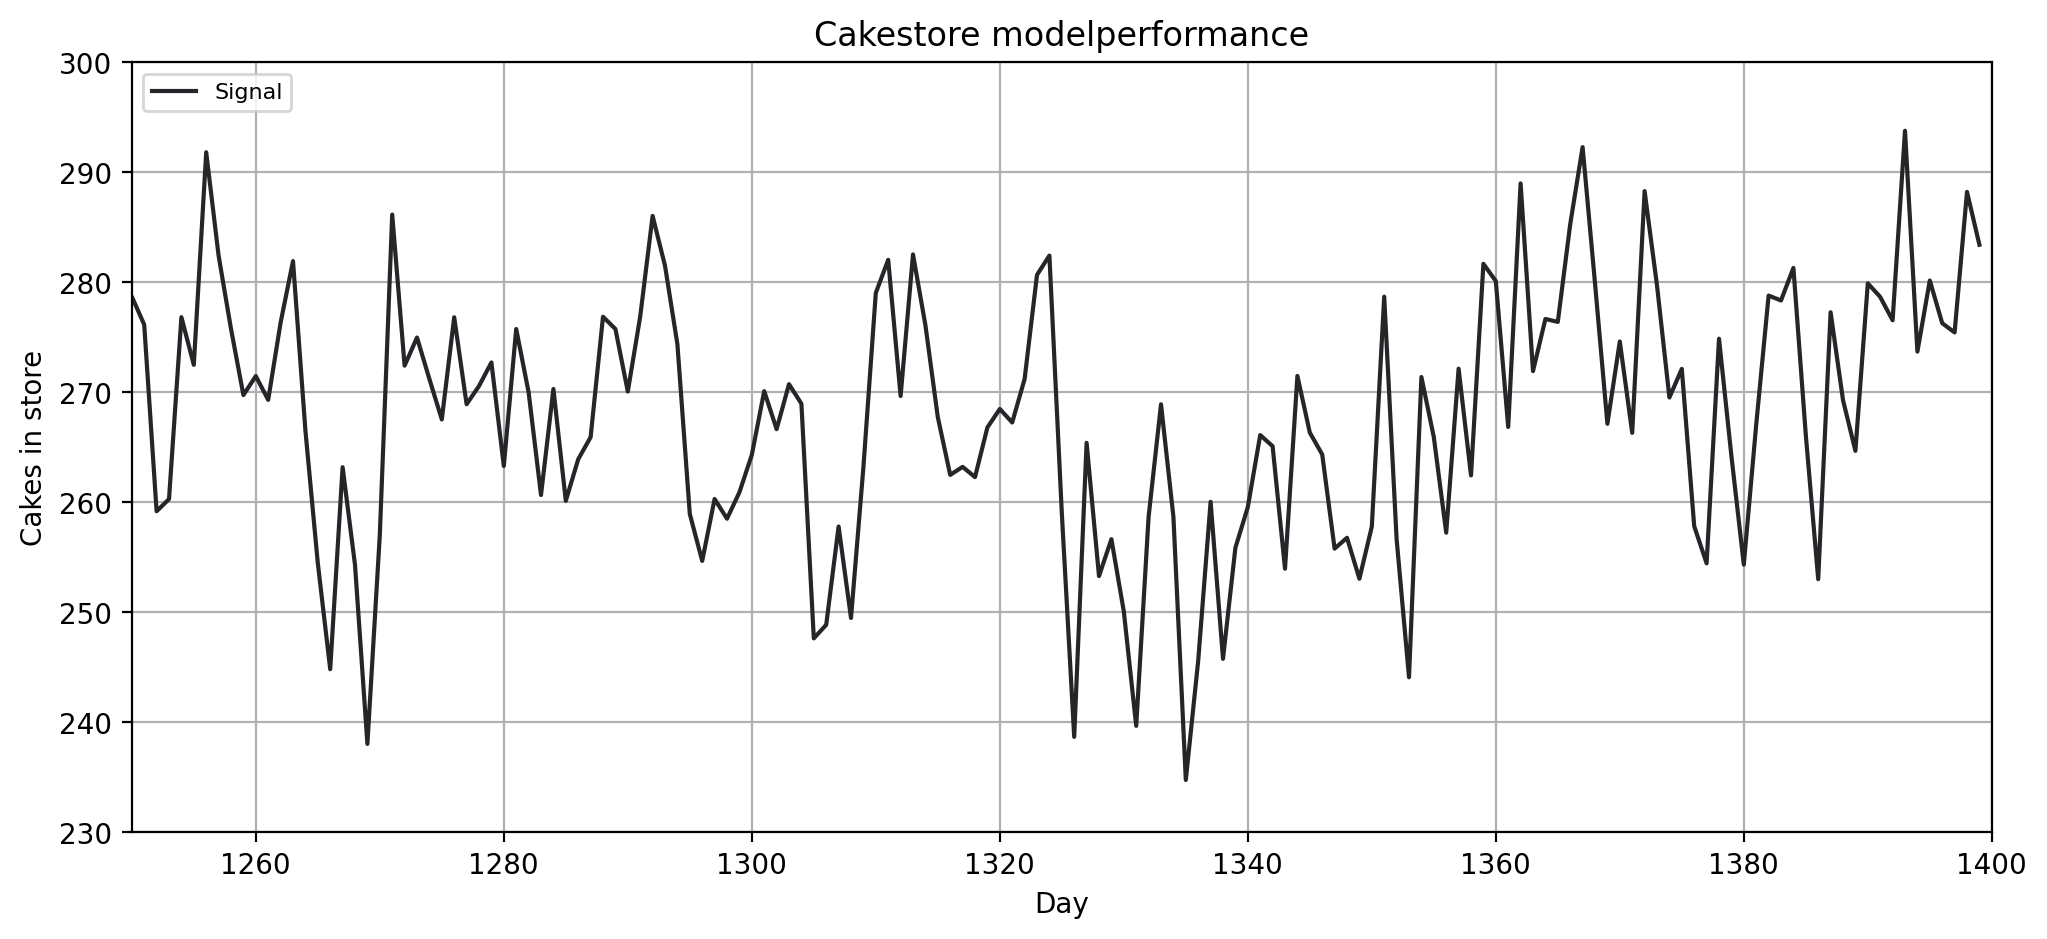

In [34]:

cakestore_modelperformance_signal()



<span style="font-size:50px">$X_t = \underbrace{0.85 X_{t-1}}_{\text{AR(1)}} \underbrace{- 0.2\varepsilon_{t-2} - 0.4\varepsilon_{t-1}}_{\text{MA(2)}} + \varepsilon_t$</span>



Now we have generated some data for our story: We used a random number generator to produce each days cake production over 1400 days and used the formula to calculate how many cakes are in stock on each day.
Now we want to train a model to see if it is capable of making good forecasts:
For that we select an AR(1)MA(2) model. We don’t give it the story, we don’t give it the weights (0,85 -0,2 -0,4) these weights are found by the model during the training


### Data Generating ARMA process example


In [35]:
print_rmse()

Train RMSE of predict_mean: 11.32
Train RMSE of predict_ARMA: 9.88
Test RMSE of predict_mean: 12.58
Test RMSE of predict_ARMA: 12.27


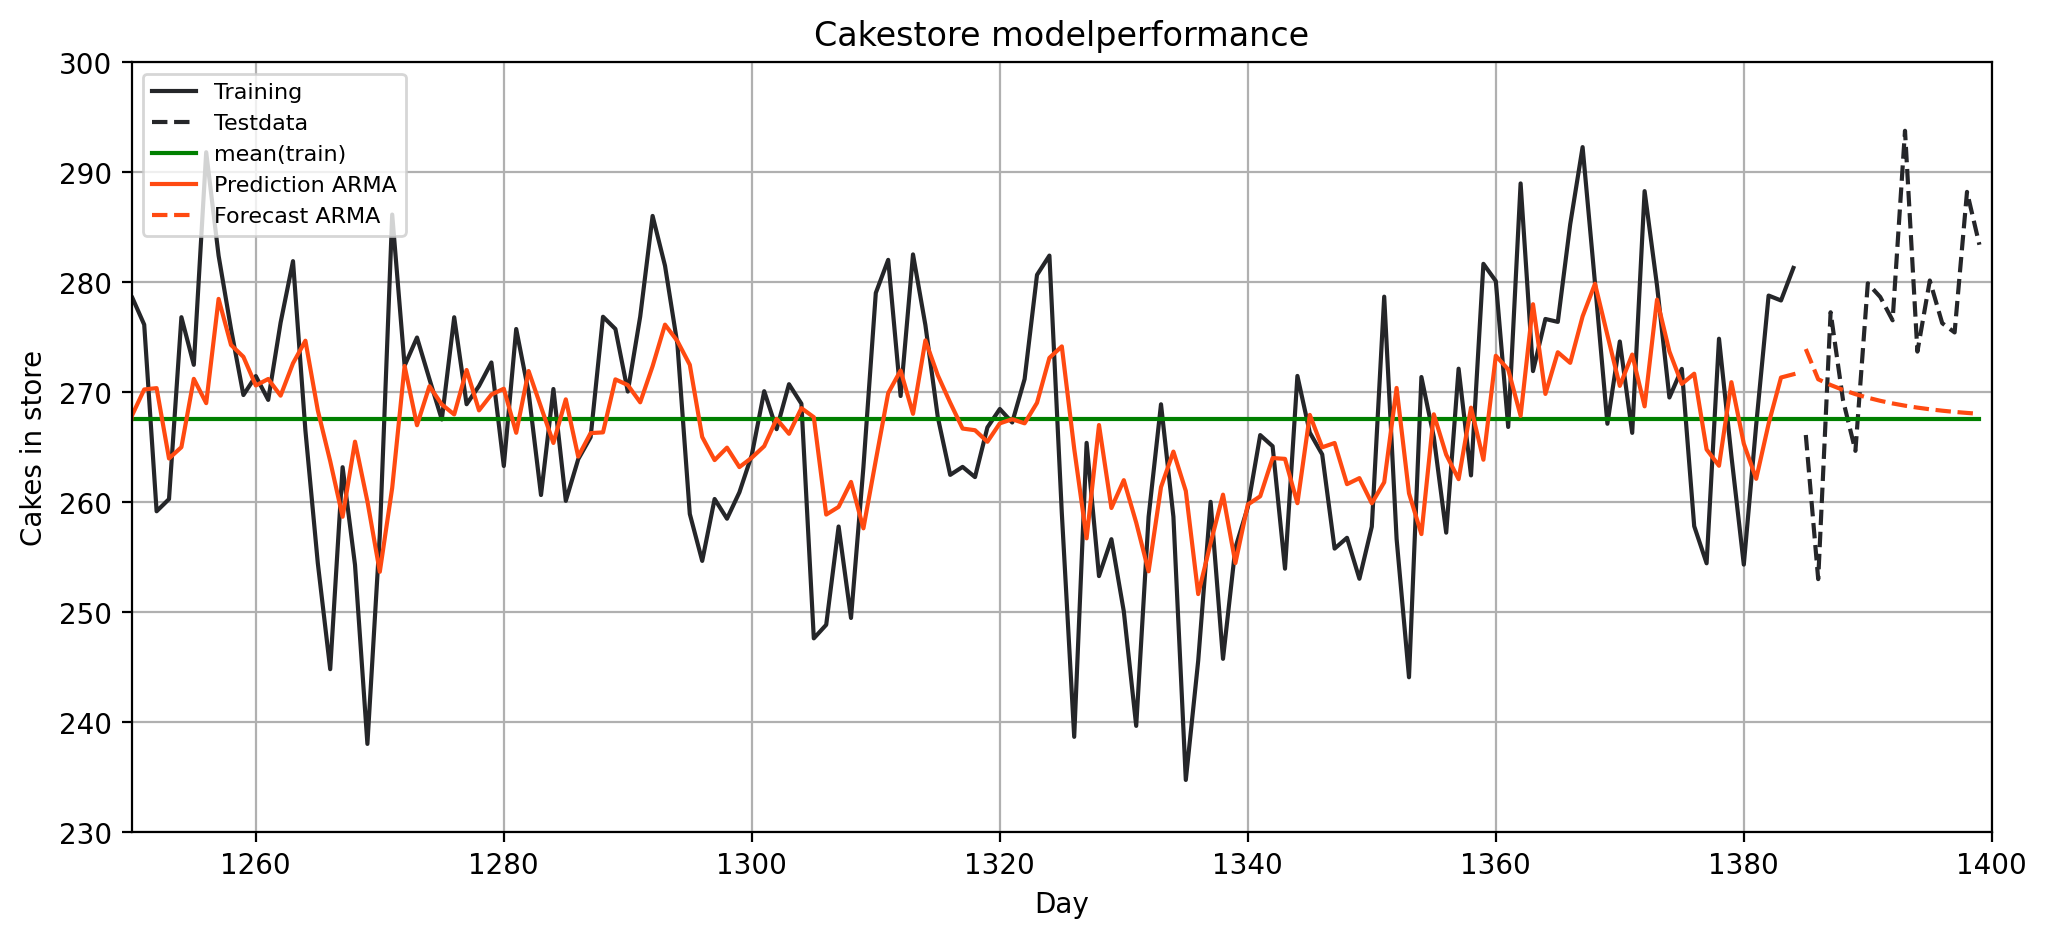

In [36]:
cakestore_modelperformance()

<span style="font-size:50px">$X_t = \underbrace{0.85 X_{t-1}}_{\text{AR(1)}} \underbrace{- 0.2\varepsilon_{t-2} - 0.4\varepsilon_{t-1}}_{\text{MA(2)}} + \varepsilon_t$</span>

Here we can see the output of our model compared to the real data:
In green we have a baseline model using the overall mean to make predictions. This leads to an RMSE of 12.57.
If we use our orange model instead, we see that we get an RMSE of 12.28. So (just slightly but) better than the baseline. It’s moving together with the actual data, which is an indication that the ARMA process can replicate the process.  The test data shows a larger error than the train. 


So why is this “relatively bad”? First, our model uses only the past two timesteps to generate the forecast. So after making 2 forecast, it is not using any new information, but just previous forecasts. That leads to this decay towards the mean line that we see here. Also the variance in epsilon is just pretty high in this example - making it hard to make a good prediction because the “random factor” has a hugh impact on the next event.

Here: Better try Markov-model

It’s generally possible to transfer an ARMA process into a pure AR or into an MA process.  


### Forecasting with ARMA

Step 1: Estimate ARMA model
* get parameters

Step 2: Use parameters to forecast
* calculate innovations recursively
* compute forecasts with observations and innovations
* software-implemented (statsmodels)

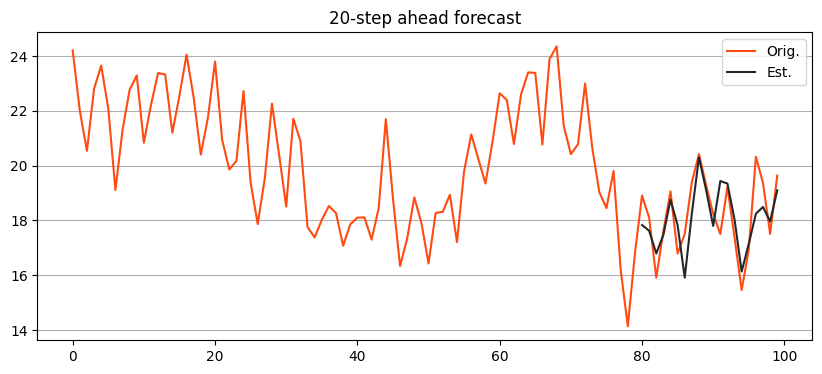

In [37]:
plot_arma()

ARMA models can in general approximate any stationary process. 

Estimating the best ARMA model is a bit witchcrafty. You can sometimes get hints from the ACF / PACF functions. Often however a gridsearch (autoarima) is used. 


### Other models from ARMA class

* ARMAX
    * Adding exogeneous variables to the model
* ARIMA
    * Adding an integrated part for non-stationarity (in the mean)
* SARIMA
    * Adding a further seasonal part to the model
* ARFIMA
    * Models with long memory
* VAR
    * Multivariate (vector) autoregressive models
* Time-Varying coefficients

* ARMAX: the added X is for exogenous. This model is able to use (1 or more) extra variables as predictors. You need to have forecasts for these predictors available! 
* ARIMA: the I is for integrated. If you know that doing X time differences make the time series stationary, you can use instead arima with an I = number of steps (X). Then the model will be able to make the series stationary.
* SARIMA: The S is for seasonality. These models can deal with seasonal effects
* ARFIMA: deep shit, used in finance. more general then arima, becaus non-integer are allowed for the differencing parameter. Leads to long series expansions and a longer memory effect. 
* VAR: Several AR models that are interacting with each other. Not super complex, but the number of interaction terms gets big quickly


## Don't worry! There is more math in the workbooks :D

<div class="group">
  <div class="text_70">
      
[The math behind AR and MA models](https://maryclare.github.io/atsa/content/notes/notes_3.pdf)
      
  </div>
  <div class="images_30">
      
<img src="../images/time_series_analysis_intro/img_p57_2.png" width="250">

      
  </div>
</div>



## The "normal" stuff
With a little trick you can also use many of the models we have used so far (often XGboost is working very well) 

In [38]:
df_acf_pacf=pd.DataFrame()
df_acf_pacf=df_acf_pacf.assign(y=y_acf_pacf)
df_acf_pacf.head(10)

,y
0,0.496714
1,0.060421
2,0.324157
3,1.660069
4,0.209006
5,-1.280167
6,1.086848
7,2.119192
8,-0.510608
9,-1.036433


In [39]:
df_acf_pacf=pd.DataFrame()
df_acf_pacf=df_acf_pacf.assign(y=y_acf_pacf)
df_acf_pacf=df_acf_pacf.assign(y=y_acf_pacf,
          y_t1=df_acf_pacf.y.shift(1),
          y_t2=df_acf_pacf.y.shift(2),
          y_t3=df_acf_pacf.y.shift(3),
          y_t4=df_acf_pacf.y.shift(4),
          y_t5=df_acf_pacf.y.shift(5),
          y_t6=df_acf_pacf.y.shift(6))
df_acf_pacf.head(10)

,y,y_t1,y_t2,y_t3,y_t4,y_t5,y_t6
0,0.496714,NaN,NaN,NaN,NaN,NaN,NaN
1,0.060421,0.496714,NaN,NaN,NaN,NaN,NaN
2,0.324157,0.060421,0.496714,NaN,NaN,NaN,NaN
3,1.660069,0.324157,0.060421,0.496714,NaN,NaN,NaN
4,0.209006,1.660069,0.324157,0.060421,0.496714,NaN,NaN
5,-1.280167,0.209006,1.660069,0.324157,0.060421,0.496714,NaN
6,1.086848,-1.280167,0.209006,1.660069,0.324157,0.060421,0.496714
7,2.119192,1.086848,-1.280167,0.209006,1.660069,0.324157,0.060421
8,-0.510608,2.119192,1.086848,-1.280167,0.209006,1.660069,0.324157
9,-1.036433,-0.510608,2.119192,1.086848,-1.280167,0.209006,1.660069


## The fancy stuff

### Facebook’s Prophet

Harvey, A.C. and Peters, S. (1990), “Estimation Procedures for Structural Time Series Models”
Taylor, S.J. and Letham, B. (2017), “Forecasting at Scale”


<div class="group">
  <div class="text_70">
      
* Library open-sourced for automated forecasting
    * Based on decomposable time series model <br />
      $x_t = g(t) + s(t) + h(t) + \varepsilon_t$ <br />
      $g(t)$ : trend function <br />
      $s(t)$ : periodic changes <br />
      $h(t)$ : holiday effects
* Time is the only feature
    * several linear and non-linear functions of time
* Needs not to be regularly spaced
* Easily interpretable
      
  </div>
  <div class="images_30">
      
<img src="../images/time_series_analysis_intro/img_p63_3.png">
      
      
<sub>[Image source](https://peerj.com/preprints/3190/)</sub>
      
  </div>
</div>

<sub>Harvey, A.C. and Peters, S. (1990), “Estimation Procedures for Structural Time Series Models” <br />
Taylor, S.J. and Letham, B. (2017), “Forecasting at Scale”</sub>

From the start the model was supposed to be easily used by analysts. Looks very similar to ARMA, but has holiday effects (which are very important for Facebook).

### Rocket

* Open-source library for time classification
* Uses CNN with >10.000 random convolutional filters
     * Then Logistic Regression
* Exceptionally fast
    * 1h 15min vs. 16h of alternative methods


<sub>Dempster, A. et al. (2019): “ROCKET: Exceptionally fast and accurate time series classification
using random convolutional kernels”</sub>

Uses Convolutional Neural Networks with various CNN filters and then use a linear classifier (e.g. logistic regression) on them to predict probabilities. 

### Convolutional neural networks

<div class="group">
  <div class="text">
      
* As with images slide the kernel over the sequence data to detect patterns
     * If the data pattern matches the filter we see spikes
* Later layers in CNNs respond to more complicated patterns, i.e. higher {specialization}
     * In 1D-convolutions we can use longer filters or add layers
     
  </div>
  <div class="images">

<img src="../images/time_series_analysis_intro/ts_cnn.png">
      
  </div>
</div>

Applying a 1-D filter that are moved along the time points are creating activations for certain patterns in a time series. Those filters are learnt, similarly to how they are learnt in the case of CNN with image data. 

### Long-Short-Term-Memory networks

<div class="group">
  <div class="text">
      
* LSTMs are special network layers that carry memory for short-term and long-term information
* Appropriateness ambiguous
    * Often do not beat exponential smoothing
    * Sometimes very good results
* Very data hungry

  </div>
  <div class="images">
      
<img src="../images/time_series_analysis_intro/Unrolled-LSTM-uses-time-series-data-as-input.png">
      
      
<sub>[Image source](https://www.researchgate.net/figure/Unrolled-LSTM-uses-time-series-data-as-input_fig1_333791434)</sub>
      
  </div>
</div>

A sub-class of Neural Networks.

In addition to standard input-output that is found in any neuron, the output is fed back into the input which creates memory.

Input vector is converted into a different vector space and outputted, in addition the hidden state is also outputted and fed to itself at the next timestep. 

The neural net is always the same, but the input into it changes. 


### Transformer models

<div class="group">
  <div class="text">
      
* A very promising model is autoformer 
* Good long-term predictions
* Very data hungry, not much experience yet
* Also, hard to predict when they will work well

 </div>
 
<div class="images">
      
<img src="../images/time_series_analysis_intro/Autoformer_architecture.png" width="500">
      
      
<sub>[source](https://huggingface.co/docs/transformers/model_doc/autoformer)</sub>
      
  </div>
</div>
[medium article](https://medium.com/mlearning-ai/transformer-implementation-for-time-series-forecasting-a9db2db5c820)
[tds article](https://towardsdatascience.com/how-to-use-transformer-networks-to-build-a-forecasting-model-297f9270e630)

## Conclusion

### Many models - where to start

As usual: with a good **EDA**
* Find what is characteristic
     
Start with **simple models**
* Exponential smoother are very good for forecasting
* ARMA models are well interpretable and allow simulations and control
     
Only **go to more complex** or specific models, **if you have** to
* and if your data amount allows you to

## Resources

* Brockwell, P.J. and Davis, R.A. “Introduction to time series and forecasting”
* Brockwell, P.J. and Davis, A.R. “Time Series Analysis”
* Heij, C. et al., “Econometric Methods With Applications in Business and Economics”
* [https://people.duke.edu/~rnau/arimrule.htm](https://people.duke.edu/~rnau/arimrule.htm)
* [Berlin Time Series Meetup Repo .. really good pointers](https://github.com/juanitorduz/btsa)
* [https://machinelearningmastery.com/multi-step-time-series-forecasting/](https://machinelearningmastery.com/multi-step-time-series-forecasting/)
* [Time Series from Scratch](https://towardsdatascience.com/tagged/time-series-from-scratch)

### ACF / PACF

In [40]:
df_acf_pacf=pd.DataFrame()
df_acf_pacf=df_acf_pacf.assign(y=y_acf_pacf)
df_acf_pacf=df_acf_pacf.assign(y=y_acf_pacf,
          yL1=df_acf_pacf.y.shift(1),
          yL2=df_acf_pacf.y.shift(2),
          yL3=df_acf_pacf.y.shift(3),
          yL4=df_acf_pacf.y.shift(4),
          yL5=df_acf_pacf.y.shift(5),
          yL6=df_acf_pacf.y.shift(6))

df_acf_pacf.head(10)

,y,yL1,yL2,yL3,yL4,yL5,yL6
0,0.496714,NaN,NaN,NaN,NaN,NaN,NaN
1,0.060421,0.496714,NaN,NaN,NaN,NaN,NaN
2,0.324157,0.060421,0.496714,NaN,NaN,NaN,NaN
3,1.660069,0.324157,0.060421,0.496714,NaN,NaN,NaN
4,0.209006,1.660069,0.324157,0.060421,0.496714,NaN,NaN
5,-1.280167,0.209006,1.660069,0.324157,0.060421,0.496714,NaN
6,1.086848,-1.280167,0.209006,1.660069,0.324157,0.060421,0.496714
7,2.119192,1.086848,-1.280167,0.209006,1.660069,0.324157,0.060421
8,-0.510608,2.119192,1.086848,-1.280167,0.209006,1.660069,0.324157
9,-1.036433,-0.510608,2.119192,1.086848,-1.280167,0.209006,1.660069


In [41]:
df_acf_pacf = df_acf_pacf.dropna()

In [42]:
display(df_acf_pacf.corr())

,y,yL1,yL2,yL3,yL4,yL5,yL6
y,1.000000,0.218849,-0.633468,-0.403532,0.293695,0.449181,-0.024383
yL1,0.218849,1.000000,0.216232,-0.636653,-0.404073,0.290718,0.442253
yL2,-0.633468,0.216232,1.000000,0.217265,-0.635846,-0.403457,0.291873
yL3,-0.403532,-0.636653,0.217265,1.000000,0.218601,-0.627985,-0.392447
yL4,0.293695,-0.404073,-0.635846,0.218601,1.000000,0.219617,-0.625264
yL5,0.449181,0.290718,-0.403457,-0.627985,0.219617,1.000000,0.219491
yL6,-0.024383,0.442253,0.291873,-0.392447,-0.625264,0.219491,1.000000


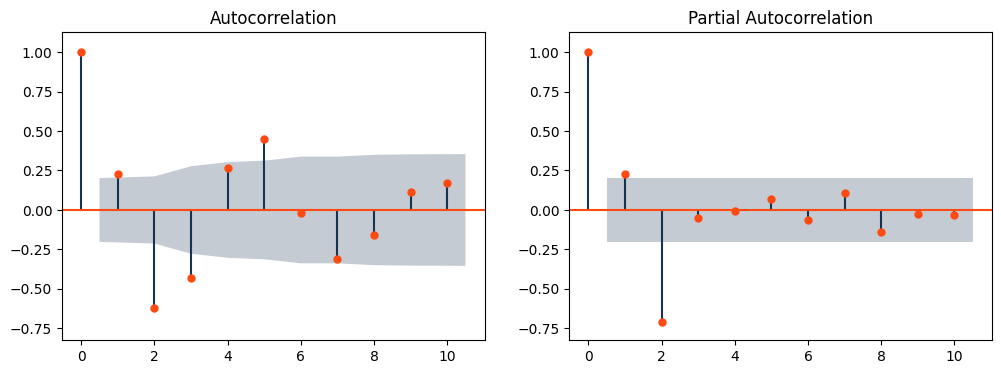

In [43]:
acf_pacf(df_acf_pacf)

They all have 0/1 as a first value (auto correlation without lag. “what is the temperatur now compared with the temperatur now. wow the same, hence 1”) 
they have the same value for the first lag. After that, they differ.

### ACF / PACF

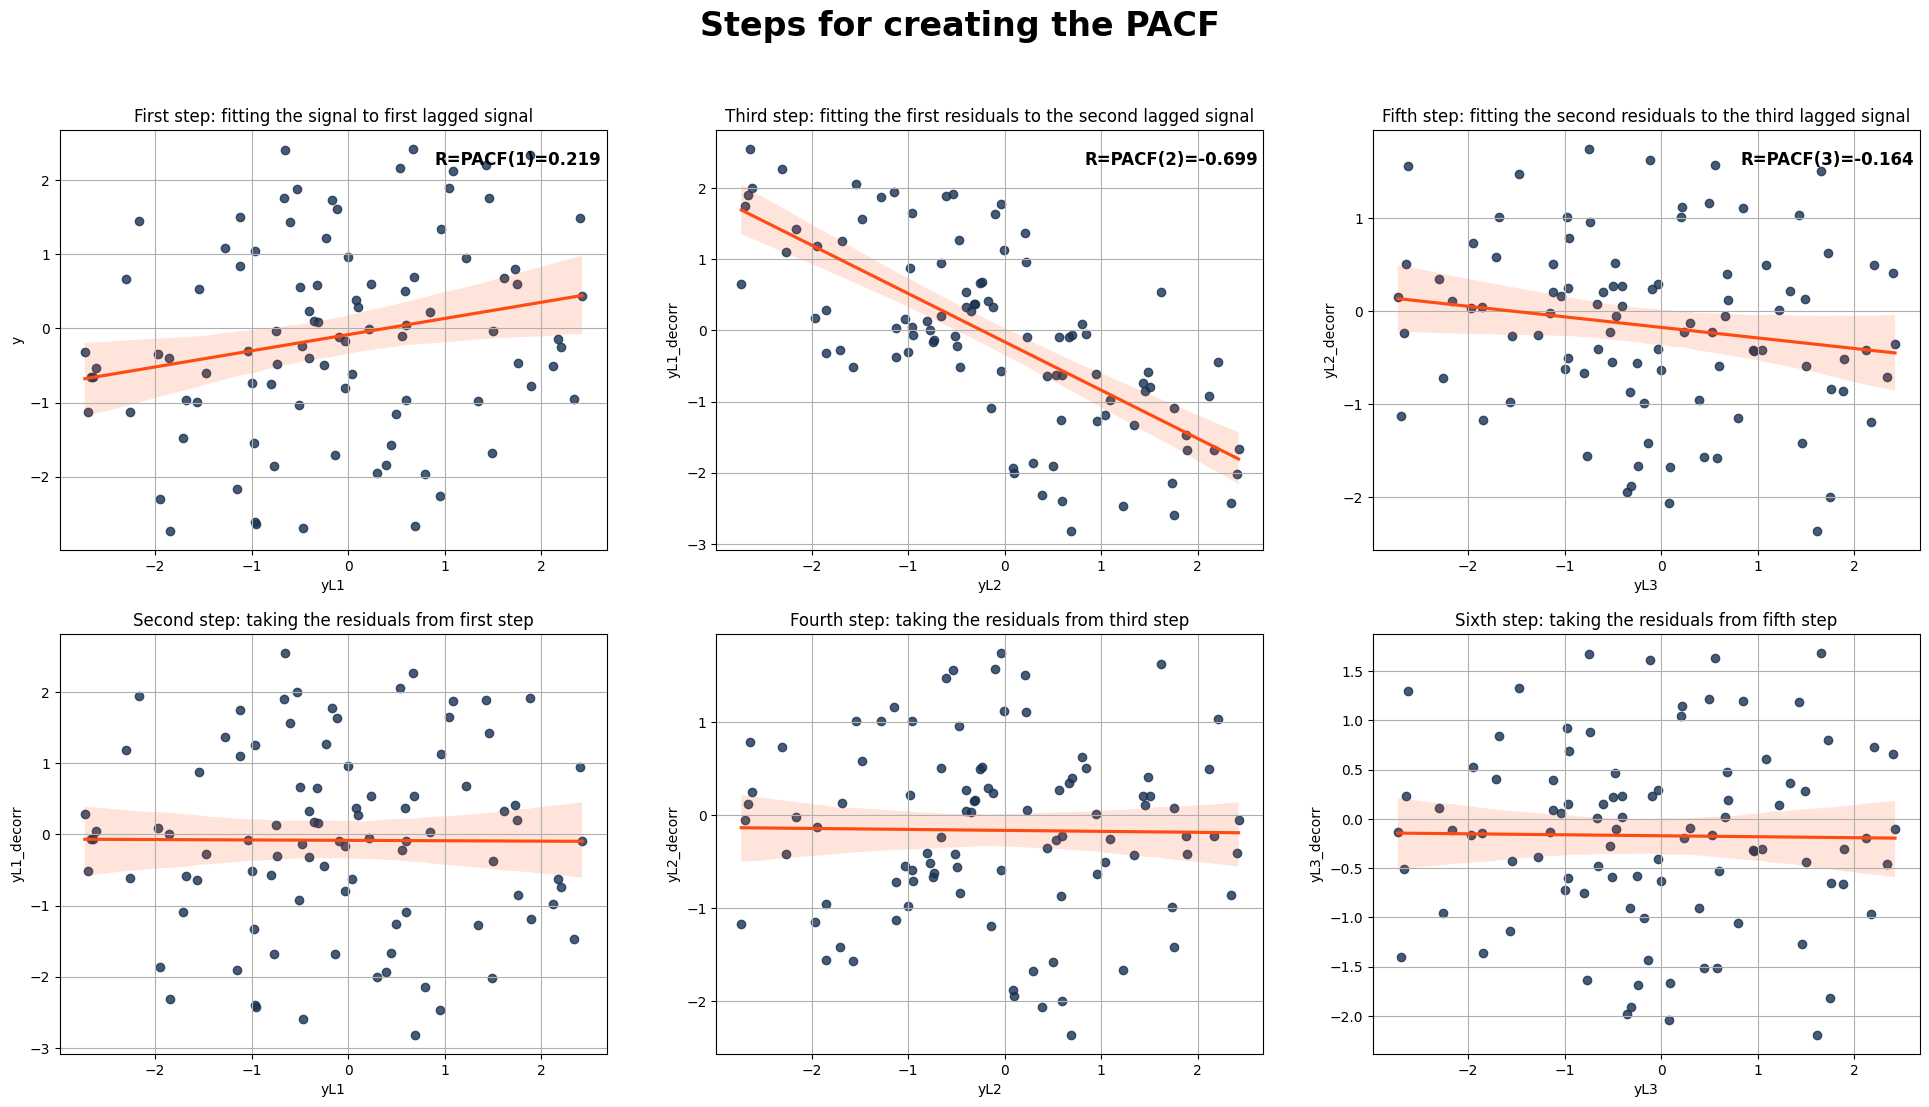

In [44]:
acf_pacf_steps(df_acf_pacf)

Step - by - step visualisation to aid explaining the difference between ACF and PACF.
For PACF, in each step the stuff that was already explained by the shorter autocorrelations is removed.
